# Data Preparation - Viral Social Media Trends Analysis

In [807]:
# Imports
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports loaded")

Imports loaded


## 1. Configurations

In [808]:
# Paths
RAW_DATA_PATH = "data/raw/Cleaned_Viral_Social_Media_Trends.csv"
PROCESSED_DIR = Path("data/processed")
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")

# Create directories
for dir_path in [PROCESSED_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    # Clear all files in directory
    for file in dir_path.glob('*'):
        if file.is_file():
            file.unlink()

# Constants
# TODO : Implement needed constraints

print("✅ Configuration loaded")


IQR_MULTIPLIER = 1.5

✅ Configuration loaded


## 2. Helper Functions

In [853]:

def calculate_iqr_bounds(series, multiplier=1.5):
    """Calculate IQR-based outlier bounds"""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - multiplier * iqr, q3 + multiplier * iqr


# TODO : Implement other Functions here - Impossible values

def build_preprocessor(nominal_cols, numeric_cols, ordinal_cols=None, ordinal_categories=None):
    """Build preprocessing pipeline - Steps 6 & 7"""
    
    if ordinal_cols is None:
        ordinal_cols = []
    if ordinal_categories is None:
        ordinal_categories = []
        
    transformers = [
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('nom', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False))
        ]), nominal_cols)
    ]
    if ordinal_cols:
        transformers.append(('ord', Pipeline([
            ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_cols))
        
    return ColumnTransformer(transformers)

def extract_feature_names(fitted_ct):
    """Extract feature names from fitted ColumnTransformer"""
    names = []
    for name, transformer, columns in fitted_ct.transformers_:
        if name == 'num':
            names.extend(columns)
        elif name == 'nom':
            names.extend(transformer.named_steps['onehot'].get_feature_names_out(columns))
        elif name == 'ord':
            names.extend(columns)
    return names

#

def categorize_rate(er):
    if er < 1:
        return "Low"
    elif er < 5:
        return "Medium"
    else:
        return "High"

print("✅ Helper functions defined")


def add_time_features(df, date_col='Post_Date'):
    # Ensure the column is datetime
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')

    # Drop rows with invalid dates
    df = df.dropna(subset=[date_col])

    # Basic time features
    df['day_of_week'] = df[date_col].dt.dayofweek       # Monday=0, Sunday=6
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['day_of_month'] = df[date_col].dt.day
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['week_of_year'] = df[date_col].dt.isocalendar().week.astype(int)
    df['month'] = df[date_col].dt.month
    df['quarter'] = df[date_col].dt.quarter
    df['year'] = df[date_col].dt.year
    df['year_month'] = df['Post_Date'].dt.to_period('M')
    return df





✅ Helper functions defined


## 3. Load Raw Data

In [810]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"✅ Loaded {len(df_raw):,} rows, {len(df_raw.columns)} columns")

# Drop unnecessary text columns immediately
df_raw = df_raw.drop(columns=['Post_ID'], errors='ignore')
print(f"✅ Dropped POST_ID column")

print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head(3)


✅ Loaded 5,000 rows, 11 columns
✅ Dropped POST_ID column

Columns: ['Post_Date', 'Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']


Post_Date   Platform     Hashtag Content_Type  Region    Views   Likes  \
0  2022-01-13     TikTok  #Challenge        Video      UK  4163464  339431   
1  2022-05-13  Instagram  #Education       Shorts   India  4155940  215240   
2  2022-01-07    Twitter  #Challenge        Video  Brazil  3666211  327143   

   Shares  Comments Engagement_Level  
0   53135     19346             High  
1   65860     27239           Medium  
2   39423     36223           Medium

## Missing Values Analysis

MISSING VALUE ANALYSIS
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Pct]
Index: []


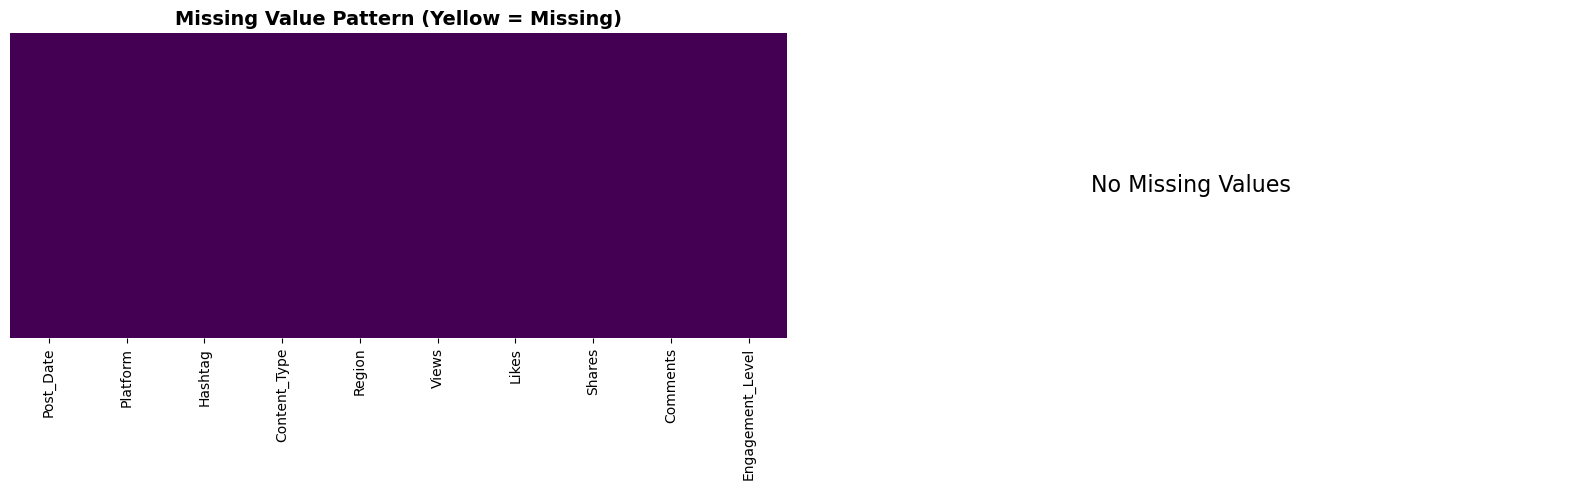


✅ Missing value analysis saved to artifacts\figures\missing_values_analysis.png

📝 Strategy: Impute after split (Step 3) using TRAIN statistics only


In [811]:
""""Missing Values Analysis before any data visualization or EDA for better understanding of data quality."""

# Missing value statistics
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)
print(missing_df[missing_df['Missing_Count'] > 0].to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax1)
ax1.set_title('Missing Value Pattern (Yellow = Missing)', fontsize=14, fontweight='bold')

# Bar chart
missing_nonzero = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_nonzero) > 0:
    ax2.barh(missing_nonzero['Column'], missing_nonzero['Missing_Pct'], color='coral', edgecolor='black')
    ax2.set_xlabel('Missing %', fontsize=12)
    ax2.set_title('Missing Value Percentage by Column', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    for i, (col, pct) in enumerate(zip(missing_nonzero['Column'], missing_nonzero['Missing_Pct'])):
        ax2.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, transform=ax2.transAxes)
    ax2.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'missing_values_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Missing value analysis saved to {FIGURES_DIR / 'missing_values_analysis.png'}")
print(f"\n📝 Strategy: Impute after split (Step 3) using TRAIN statistics only")


## Exploratory Data Analysis

In [812]:

print("Data Summary:")
print("*"*60)
print(df_raw.describe())
print(f"\n✅ EDA complete - Ready for STEP 2: Split")

Data Summary:
************************************************************
              Views          Likes        Shares      Comments
count  5.000000e+03    5000.000000   5000.000000   5000.000000
mean   2.494066e+06  251475.029800  50519.562000  24888.393800
std    1.459490e+06  144349.583384  29066.362671  14284.504319
min    1.266000e+03     490.000000     52.000000     18.000000
25%    1.186207e+06  126892.250000  25029.000000  12305.250000
50%    2.497373e+06  249443.000000  50839.500000  25004.000000
75%    3.759781e+06  373970.750000  75774.250000  37072.750000
max    4.999430e+06  499922.000000  99978.000000  49993.000000

✅ EDA complete - Ready for STEP 2: Split


In [813]:
df_raw.describe()

Views          Likes        Shares      Comments
count  5.000000e+03    5000.000000   5000.000000   5000.000000
mean   2.494066e+06  251475.029800  50519.562000  24888.393800
std    1.459490e+06  144349.583384  29066.362671  14284.504319
min    1.266000e+03     490.000000     52.000000     18.000000
25%    1.186207e+06  126892.250000  25029.000000  12305.250000
50%    2.497373e+06  249443.000000  50839.500000  25004.000000
75%    3.759781e+06  373970.750000  75774.250000  37072.750000
max    4.999430e+06  499922.000000  99978.000000  49993.000000

In [814]:
# Identify unique values
df_raw.describe(include='object')
for col in df_raw.select_dtypes(include='object').columns:
    print(f"\n{col}: {df_raw[col].nunique()} unique values")
    print(df_raw[col].unique())


Post_Date: 729 unique values
['2022-01-13' '2022-05-13' '2022-01-07' '2022-12-05' '2023-03-23'
 '2022-11-23' '2022-06-09' '2022-01-14' '2022-09-01' '2023-01-01'
 '2023-08-09' '2023-02-26' '2022-03-16' '2022-11-08' '2023-12-19'
 '2022-04-05' '2023-07-09' '2022-09-17' '2022-05-08' '2023-04-24'
 '2023-08-15' '2022-01-26' '2023-08-02' '2023-07-19' '2022-09-08'
 '2023-05-14' '2022-05-22' '2023-09-30' '2023-10-23' '2022-03-22'
 '2022-03-10' '2022-07-08' '2022-11-11' '2023-11-18' '2023-07-01'
 '2023-07-15' '2022-09-28' '2022-01-31' '2022-03-03' '2022-03-17'
 '2022-09-10' '2023-03-06' '2023-12-13' '2023-06-02' '2023-11-07'
 '2023-04-29' '2022-08-15' '2022-05-23' '2023-01-14' '2022-11-06'
 '2023-09-17' '2023-01-13' '2023-08-25' '2022-06-30' '2022-10-30'
 '2023-12-26' '2023-05-31' '2023-04-21' '2023-10-24' '2023-02-23'
 '2023-12-05' '2023-12-11' '2022-11-03' '2023-05-26' '2023-06-10'
 '2022-01-20' '2022-02-05' '2022-05-16' '2022-01-19' '2022-12-07'
 '2022-06-12' '2023-05-08' '2023-05-12' '2022-

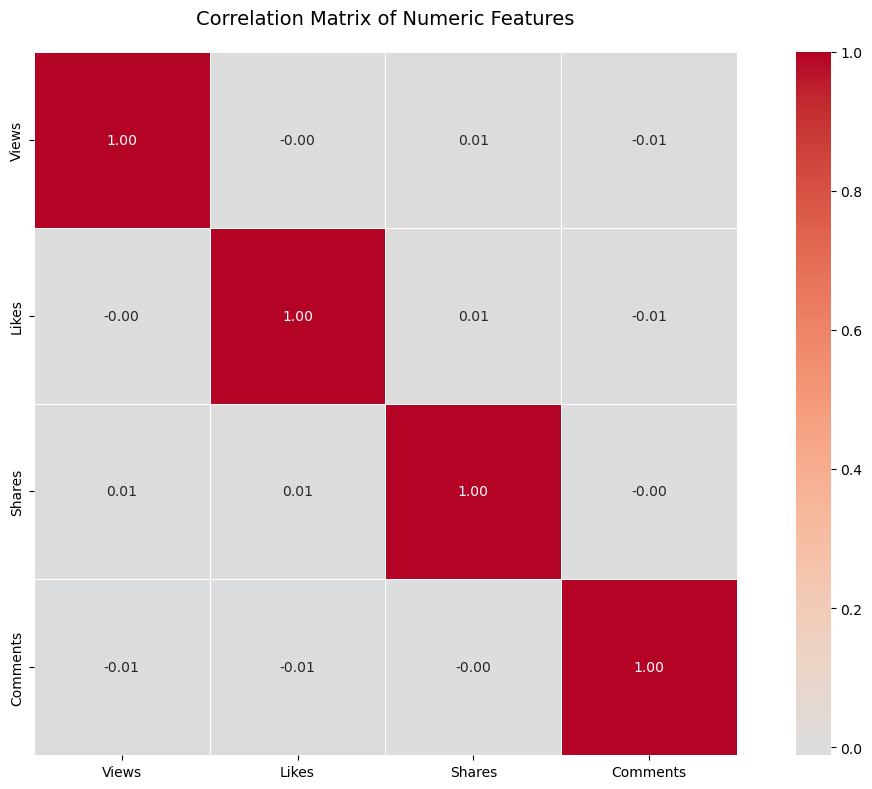


✅ Correlation analysis saved to artifacts\figures\correlation_matrix.png


In [815]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df_raw.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_raw[numeric_cols].corr()

# Create heatmap
sns.heatmap(
            correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5
            )

plt.title('Correlation Matrix of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Correlation analysis saved to {FIGURES_DIR / 'correlation_matrix.png'}")


### Data Visualization

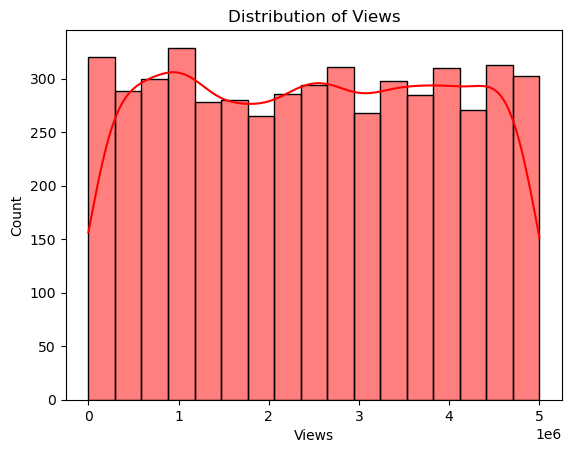

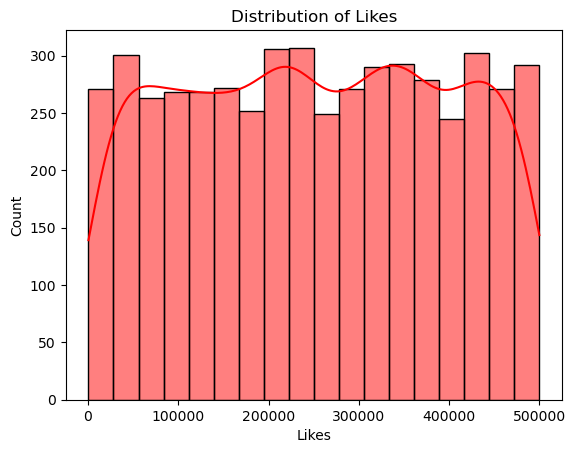

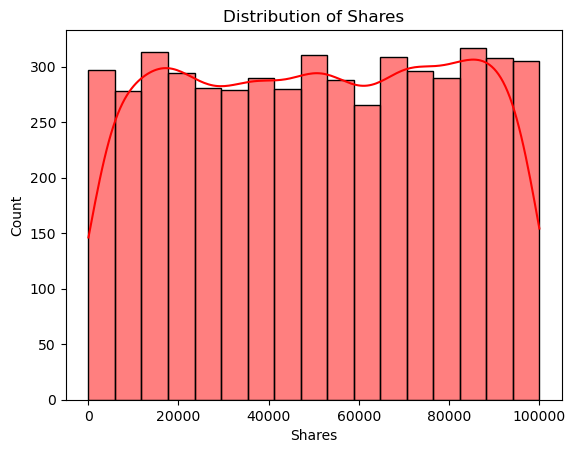

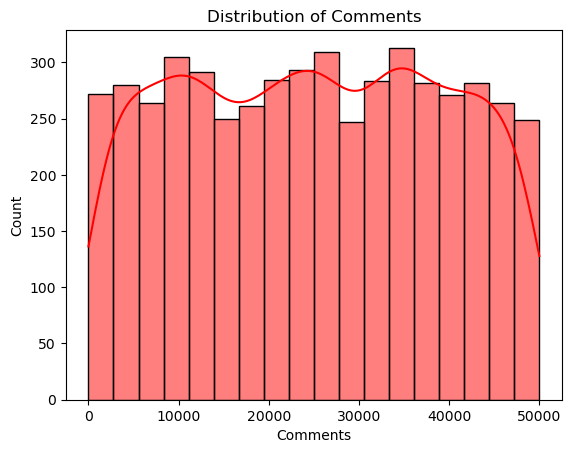

In [816]:
# Histograms for distribution
for i in df_raw.select_dtypes(include="number").columns:
    sns.histplot(data=df_raw, x=i, kde=True, color="red")
    plt.title(f'Distribution of {i}')
    plt.savefig(FIGURES_DIR / f'Histogram-distribution of {i}.png', dpi=150, bbox_inches='tight')
    plt.tight_layout
    plt.show()

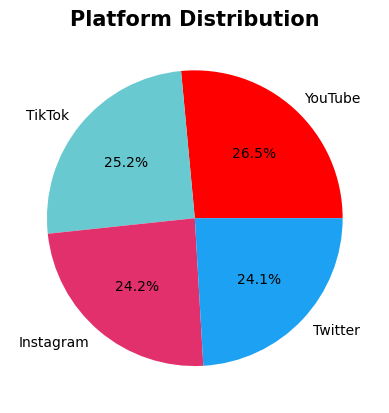

In [817]:
count = df_raw['Platform'].value_counts()
colors = ["#FF0000", "#69C9D0", "#E1306C", "#1DA1F2"]
plt.pie(count, labels=count.index, colors=colors ,autopct='%1.1f%%')
plt.title('Platform Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'PieChart.png', dpi=150, bbox_inches='tight')
plt.show()

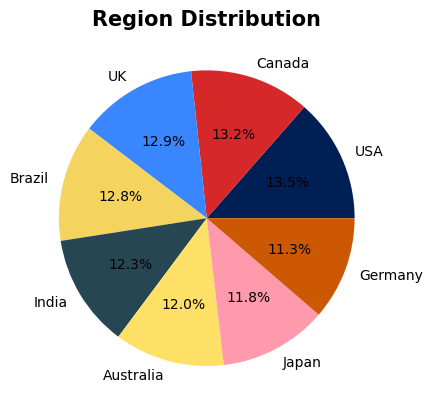

In [818]:
region_distribution = df_raw['Region'].value_counts()
colors = [ "#001f54" ,"#d62828","#3a86ff","#f4d35e","#264653","#ffe066","#ff99ac","#cc5803","#001f54" ,"#d62828" ]
plt.pie(region_distribution, labels=region_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Region Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'Region Piechart.png', dpi=150, bbox_inches='tight')
plt.show()

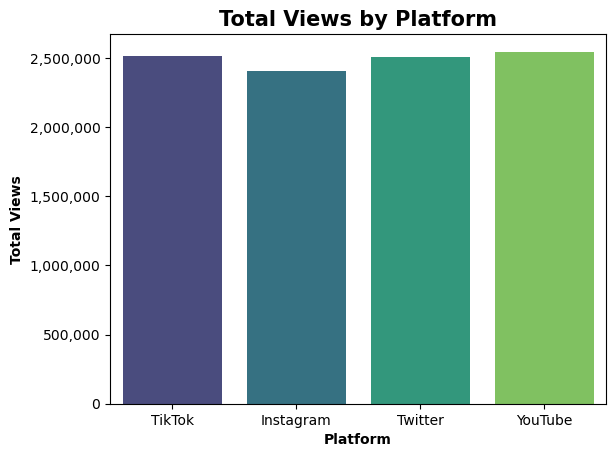

In [819]:
from matplotlib.ticker import FuncFormatter
sns.barplot(x='Platform', y='Views',data=df_raw, palette='viridis',ci=False)
plt.title('Total Views by Platform', fontsize=15 , weight='bold')
plt.xlabel('Platform', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Platform.png', dpi=150, bbox_inches='tight')
plt.show()

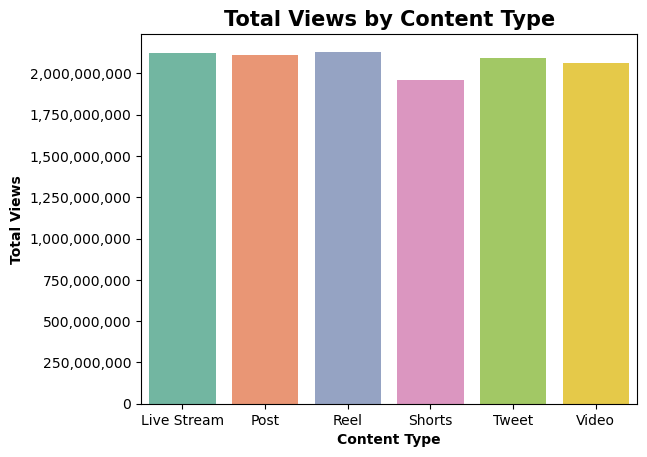

In [820]:
content_views = df_raw.groupby('Content_Type')['Views'].sum().reset_index()
sns.barplot(x='Content_Type', y='Views', data=content_views, palette='Set2')
plt.title('Total Views by Content Type', fontsize=15 , weight='bold')
plt.xlabel('Content Type', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-ContentType.png', dpi=150, bbox_inches='tight')
plt.show()

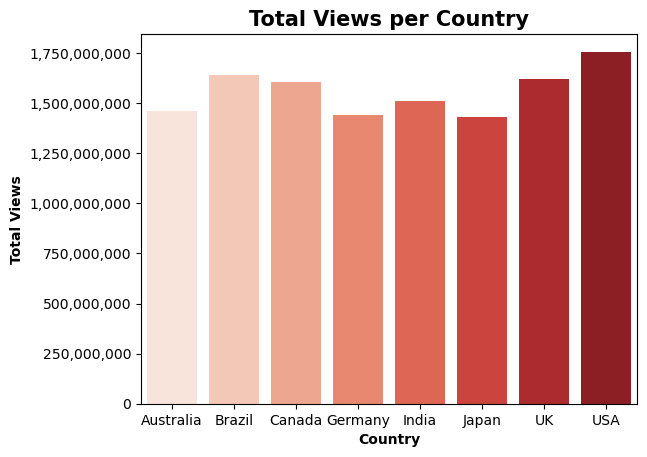

In [821]:
views_per_country = df_raw.groupby('Region')['Views'].sum()
sns.barplot(x=views_per_country.index, y=views_per_country.values , palette='Reds')
plt.title('Total Views per Country', fontsize=15 , weight='bold')
plt.xlabel('Country', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Country.png', dpi=150, bbox_inches='tight')
plt.show()

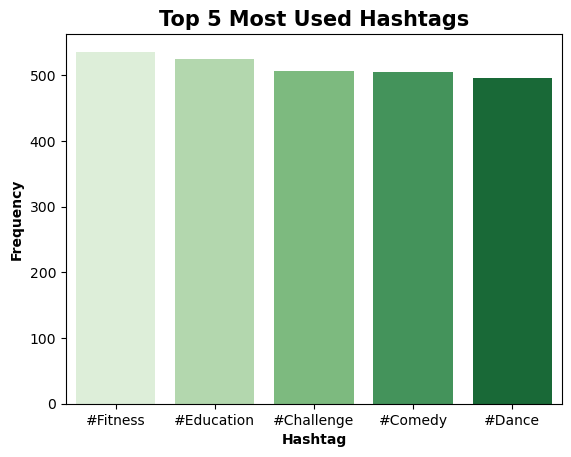

In [822]:
most5_used_hastags = df_raw['Hashtag'].value_counts().sort_values(ascending=False).nlargest(5)
sns.barplot(x=most5_used_hastags.index, y=most5_used_hastags.values, palette='Greens')
plt.title('Top 5 Most Used Hashtags', fontsize=15 , weight='bold')
plt.xlabel('Hashtag', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.savefig(FIGURES_DIR / f'Barchart-Hashtags.png', dpi=150, bbox_inches='tight')
plt.show()

### Core metrics Investigation

In [823]:
# Identify rows where engagement seems inconsistent

#Likes are greater than views
df_raw[df_raw['Likes'] > df_raw['Views']]





Post_Date   Platform   Hashtag Content_Type     Region   Views   Likes  \
4     2023-03-23     TikTok    #Dance         Post     Brazil   64866  171361   
20    2023-08-15    Twitter   #Gaming        Video     Brazil   14095  268310   
36    2022-06-09  Instagram    #Music         Reel    Germany   48908  205884   
45    2023-12-13  Instagram   #Gaming        Tweet     Brazil  272327  274271   
81    2023-08-06  Instagram    #Dance  Live Stream  Australia  284772  338933   
...          ...        ...       ...          ...        ...     ...     ...   
4944  2022-05-08     TikTok   #Comedy        Video  Australia   31732  140297   
4957  2023-05-19  Instagram  #Fitness  Live Stream  Australia   38930  295330   
4970  2022-12-13    Twitter  #Fitness  Live Stream        USA  263389  330087   
4985  2023-12-14     TikTok    #Music  Live Stream      India  379978  409651   
4991  2022-01-07  Instagram  #Fashion       Shorts     Brazil   10157  322897   

      Shares  Comments Engagement_Level  
4      69581      6376           Medium  
20     90495     16968              Low  
36     37256     14618              Low  
45     56073     17526             High  
81     22771     18899              Low  
...      ...       ...              ...  
4944   38920      3503           Medium  
4957   60125     42066             High  
4970   71596     11742              Low  
4985   84380     34427              Low  
4991   93292     23766             High  

[268 rows x 10 columns]

In [824]:
#Shares are greater than views
df_raw[df_raw['Shares'] > df_raw['Views']]

Post_Date   Platform     Hashtag Content_Type     Region  Views  \
4     2023-03-23     TikTok      #Dance         Post     Brazil  64866   
20    2023-08-15    Twitter     #Gaming        Video     Brazil  14095   
104   2023-04-17  Instagram    #Fitness         Post      Japan  13562   
430   2023-09-24    Twitter     #Gaming        Video      India  40081   
621   2022-06-20    YouTube    #Fitness  Live Stream        USA  93786   
800   2022-03-09  Instagram      #Dance         Reel     Canada  34258   
918   2023-07-19    Twitter      #Viral        Tweet     Canada   6651   
1033  2022-09-06  Instagram  #Education        Tweet  Australia  11338   
1097  2022-08-14    YouTube    #Fashion        Tweet         UK  97528   
1399  2023-01-11  Instagram     #Comedy  Live Stream  Australia  23823   
1513  2023-10-26  Instagram     #Gaming         Post     Canada  18259   
1537  2022-04-22    YouTube  #Challenge        Video     Canada  20509   
1540  2023-11-01  Instagram     #Comedy  Live Stream      Japan   4323   
1578  2022-08-15    Twitter    #Fitness         Post      India  57621   
1617  2022-01-02  Instagram  #Education       Shorts         UK  55629   
1703  2022-10-08     TikTok     #Comedy         Post  Australia  28489   
1738  2022-02-07    YouTube     #Gaming  Live Stream  Australia  51815   
1834  2022-09-12    YouTube      #Dance        Tweet  Australia  21300   
1948  2022-07-22    YouTube  #Challenge         Post     Canada  54853   
2111  2023-10-17    YouTube      #Dance         Post     Brazil  16410   
2232  2023-11-28     TikTok      #Viral         Reel         UK  28185   
2253  2023-11-19     TikTok  #Education        Tweet      Japan  37444   
2567  2022-02-07     TikTok    #Fashion        Tweet         UK  33485   
2592  2023-06-16     TikTok    #Fashion        Video     Brazil  36380   
2647  2023-05-25    YouTube  #Challenge         Post        USA   8982   
2709  2023-09-19  Instagram    #Fitness        Tweet     Brazil  12365   
2957  2022-06-15     TikTok    #Fitness        Tweet      Japan  22280   
3065  2023-07-17    Twitter      #Music  Live Stream         UK  30878   
3284  2022-12-27  Instagram      #Viral  Live Stream      India  39781   
3451  2022-01-26     TikTok       #Tech        Video        USA  42222   
3455  2023-04-30  Instagram    #Fitness        Tweet      India  52567   
3686  2023-06-27    YouTube       #Tech  Live Stream         UK   5467   
3813  2023-05-01    YouTube    #Fitness         Reel      India  54266   
3926  2022-06-22  Instagram    #Fitness  Live Stream        USA  39409   
3957  2023-07-29  Instagram      #Dance         Post     Brazil  26531   
4137  2022-12-18  Instagram     #Comedy        Tweet     Canada  13578   
4284  2023-10-13    YouTube     #Gaming  Live Stream    Germany   7810   
4473  2023-12-26  Instagram     #Comedy       Shorts        USA  46451   
4571  2023-03-04     TikTok     #Gaming        Video        USA   5679   
4588  2022-12-25  Instagram     #Gaming         Reel        USA  27994   
4691  2022-07-31    Twitter  #Education       Shorts      India   8162   
4713  2022-11-26     TikTok      #Music        Tweet        USA  40261   
4738  2022-05-25     TikTok      #Dance         Reel         UK  50550   
4771  2022-12-18  Instagram      #Viral         Reel  Australia  17410   
4826  2023-09-03     TikTok      #Viral       Shorts        USA   1266   
4860  2022-01-14    YouTube    #Fashion         Post  Australia  64334   
4889  2023-05-06    Twitter     #Gaming         Reel      India  40996   
4944  2022-05-08     TikTok     #Comedy        Video  Australia  31732   
4957  2023-05-19  Instagram    #Fitness  Live Stream  Australia  38930   
4991  2022-01-07  Instagram    #Fashion       Shorts     Brazil  10157   

       Likes  Shares  Comments Engagement_Level  
4     171361   69581      6376           Medium  
20    268310   90495     16968              Low  
104    11483   33641     30457           Medium  
430   388209   72017     26138  

In [825]:

#Comments greater than views
df_raw[df_raw['Comments'] > df_raw['Views']]



Post_Date   Platform     Hashtag Content_Type     Region  Views  \
20    2023-08-15    Twitter     #Gaming        Video     Brazil  14095   
104   2023-04-17  Instagram    #Fitness         Post      Japan  13562   
415   2022-03-23    Twitter      #Music        Tweet      India  17826   
529   2023-10-27    Twitter       #Tech         Reel        USA  18921   
918   2023-07-19    Twitter      #Viral        Tweet     Canada   6651   
1033  2022-09-06  Instagram  #Education        Tweet  Australia  11338   
1399  2023-01-11  Instagram     #Comedy  Live Stream  Australia  23823   
1513  2023-10-26  Instagram     #Gaming         Post     Canada  18259   
1537  2022-04-22    YouTube  #Challenge        Video     Canada  20509   
1540  2023-11-01  Instagram     #Comedy  Live Stream      Japan   4323   
1834  2022-09-12    YouTube      #Dance        Tweet  Australia  21300   
1916  2022-01-21    YouTube      #Music  Live Stream     Canada  29816   
2352  2023-06-27    YouTube    #Fitness         Reel        USA  16896   
2647  2023-05-25    YouTube  #Challenge         Post        USA   8982   
2957  2022-06-15     TikTok    #Fitness        Tweet      Japan  22280   
3686  2023-06-27    YouTube       #Tech  Live Stream         UK   5467   
3926  2022-06-22  Instagram    #Fitness  Live Stream        USA  39409   
3957  2023-07-29  Instagram      #Dance         Post     Brazil  26531   
4137  2022-12-18  Instagram     #Comedy        Tweet     Canada  13578   
4571  2023-03-04     TikTok     #Gaming        Video        USA   5679   
4691  2022-07-31    Twitter  #Education       Shorts      India   8162   
4826  2023-09-03     TikTok      #Viral       Shorts        USA   1266   
4889  2023-05-06    Twitter     #Gaming         Reel      India  40996   
4957  2023-05-19  Instagram    #Fitness  Live Stream  Australia  38930   
4991  2022-01-07  Instagram    #Fashion       Shorts     Brazil  10157   

       Likes  Shares  Comments Engagement_Level  
20    268310   90495     16968              Low  
104    11483   33641     30457           Medium  
415   347482   13497     25800           Medium  
529   150828    7751     27357           Medium  
918    22479   24947     11283           Medium  
1033  379782   86100     44273           Medium  
1399   40878   92816     32364           Medium  
1513  325660   50504     27761              Low  
1537  237516   66323     41897           Medium  
1540  301571   81786     30318              Low  
1834  339452   57791     30571             High  
1916  396506     411     41454              Low  
2352  474590    4148     49986              Low  
2647  353646   77267     39542           Medium  
2957  294546   89803     22578           Medium  
3686  337597   79716     33748             High  
3926   71007   41600     46694             High  
3957  366987   95517     48128              Low  
4137  485916   39122     29109             High  
4571   95171   63079     40180           Medium  
4691  285470   60984     43541             High  
4826  318849    1715     36121             High  
4889  495489   67515     42200              Low  
4957  295330   60125     42066             High  
4991  322897   93292     23766             High

In [826]:
# Identify rows where all greater than views
df_raw[(df_raw['Likes'] > df_raw['Views']) &
       (df_raw['Shares'] > df_raw['Views']) &
       (df_raw['Comments'] > df_raw['Views'])] 

Post_Date   Platform     Hashtag Content_Type     Region  Views  \
20    2023-08-15    Twitter     #Gaming        Video     Brazil  14095   
918   2023-07-19    Twitter      #Viral        Tweet     Canada   6651   
1033  2022-09-06  Instagram  #Education        Tweet  Australia  11338   
1399  2023-01-11  Instagram     #Comedy  Live Stream  Australia  23823   
1513  2023-10-26  Instagram     #Gaming         Post     Canada  18259   
1537  2022-04-22    YouTube  #Challenge        Video     Canada  20509   
1540  2023-11-01  Instagram     #Comedy  Live Stream      Japan   4323   
1834  2022-09-12    YouTube      #Dance        Tweet  Australia  21300   
2647  2023-05-25    YouTube  #Challenge         Post        USA   8982   
2957  2022-06-15     TikTok    #Fitness        Tweet      Japan  22280   
3686  2023-06-27    YouTube       #Tech  Live Stream         UK   5467   
3926  2022-06-22  Instagram    #Fitness  Live Stream        USA  39409   
3957  2023-07-29  Instagram      #Dance         Post     Brazil  26531   
4137  2022-12-18  Instagram     #Comedy        Tweet     Canada  13578   
4571  2023-03-04     TikTok     #Gaming        Video        USA   5679   
4691  2022-07-31    Twitter  #Education       Shorts      India   8162   
4826  2023-09-03     TikTok      #Viral       Shorts        USA   1266   
4889  2023-05-06    Twitter     #Gaming         Reel      India  40996   
4957  2023-05-19  Instagram    #Fitness  Live Stream  Australia  38930   
4991  2022-01-07  Instagram    #Fashion       Shorts     Brazil  10157   

       Likes  Shares  Comments Engagement_Level  
20    268310   90495     16968              Low  
918    22479   24947     11283           Medium  
1033  379782   86100     44273           Medium  
1399   40878   92816     32364           Medium  
1513  325660   50504     27761              Low  
1537  237516   66323     41897           Medium  
1540  301571   81786     30318              Low  
1834  339452   57791     30571             High  
2647  353646   77267     39542           Medium  
2957  294546   89803     22578           Medium  
3686  337597   79716     33748             High  
3926   71007   41600     46694             High  
3957  366987   95517     48128              Low  
4137  485916   39122     29109             High  
4571   95171   63079     40180           Medium  
4691  285470   60984     43541             High  
4826  318849    1715     36121             High  
4889  495489   67515     42200              Low  
4957  295330   60125     42066             High  
4991  322897   93292     23766             High

In [827]:
# Identify rows where one is greater than views
df_raw[(df_raw['Likes'] > df_raw['Views']) |
       (df_raw['Shares'] > df_raw['Views']) |
       (df_raw['Comments'] > df_raw['Views'])]

Post_Date   Platform   Hashtag Content_Type     Region   Views   Likes  \
4     2023-03-23     TikTok    #Dance         Post     Brazil   64866  171361   
20    2023-08-15    Twitter   #Gaming        Video     Brazil   14095  268310   
36    2022-06-09  Instagram    #Music         Reel    Germany   48908  205884   
45    2023-12-13  Instagram   #Gaming        Tweet     Brazil  272327  274271   
81    2023-08-06  Instagram    #Dance  Live Stream  Australia  284772  338933   
...          ...        ...       ...          ...        ...     ...     ...   
4944  2022-05-08     TikTok   #Comedy        Video  Australia   31732  140297   
4957  2023-05-19  Instagram  #Fitness  Live Stream  Australia   38930  295330   
4970  2022-12-13    Twitter  #Fitness  Live Stream        USA  263389  330087   
4985  2023-12-14     TikTok    #Music  Live Stream      India  379978  409651   
4991  2022-01-07  Instagram  #Fashion       Shorts     Brazil   10157  322897   

      Shares  Comments Engagement_Level  
4      69581      6376           Medium  
20     90495     16968              Low  
36     37256     14618              Low  
45     56073     17526             High  
81     22771     18899              Low  
...      ...       ...              ...  
4944   38920      3503           Medium  
4957   60125     42066             High  
4970   71596     11742              Low  
4985   84380     34427              Low  
4991   93292     23766             High  

[270 rows x 10 columns]

In [828]:
df_raw.describe()

Views          Likes        Shares      Comments
count  5.000000e+03    5000.000000   5000.000000   5000.000000
mean   2.494066e+06  251475.029800  50519.562000  24888.393800
std    1.459490e+06  144349.583384  29066.362671  14284.504319
min    1.266000e+03     490.000000     52.000000     18.000000
25%    1.186207e+06  126892.250000  25029.000000  12305.250000
50%    2.497373e+06  249443.000000  50839.500000  25004.000000
75%    3.759781e+06  373970.750000  75774.250000  37072.750000
max    4.999430e+06  499922.000000  99978.000000  49993.000000

## Define feature columns

### Anomaly Investigation


STEP 3: Anomaly Flag Creation (Safe - Before Split)
Likes anomalies: 268 (5.4%)
Shares anomalies: 50 (1.0%)
Comments anomalies: 25 (0.5%)
Any anomaly: 270 (5.4%)

STEP 4: Anomaly Pattern Analysis

📊 Anomalies by Platform:
          likes_anomaly shares_anomaly comments_anomaly any_anomaly       
                    sum            sum              sum         sum   mean
Platform                                                                  
Instagram            79             18               10          80  0.066
TikTok               68             13                3          68  0.054
Twitter              70              7                6          70  0.058
YouTube              51             12                6          52  0.039

📊 Anomalies by Hashtag:
           likes_anomaly shares_anomaly comments_anomaly any_anomaly       
                     sum            sum              sum         sum   mean
Hashtag                                                                    

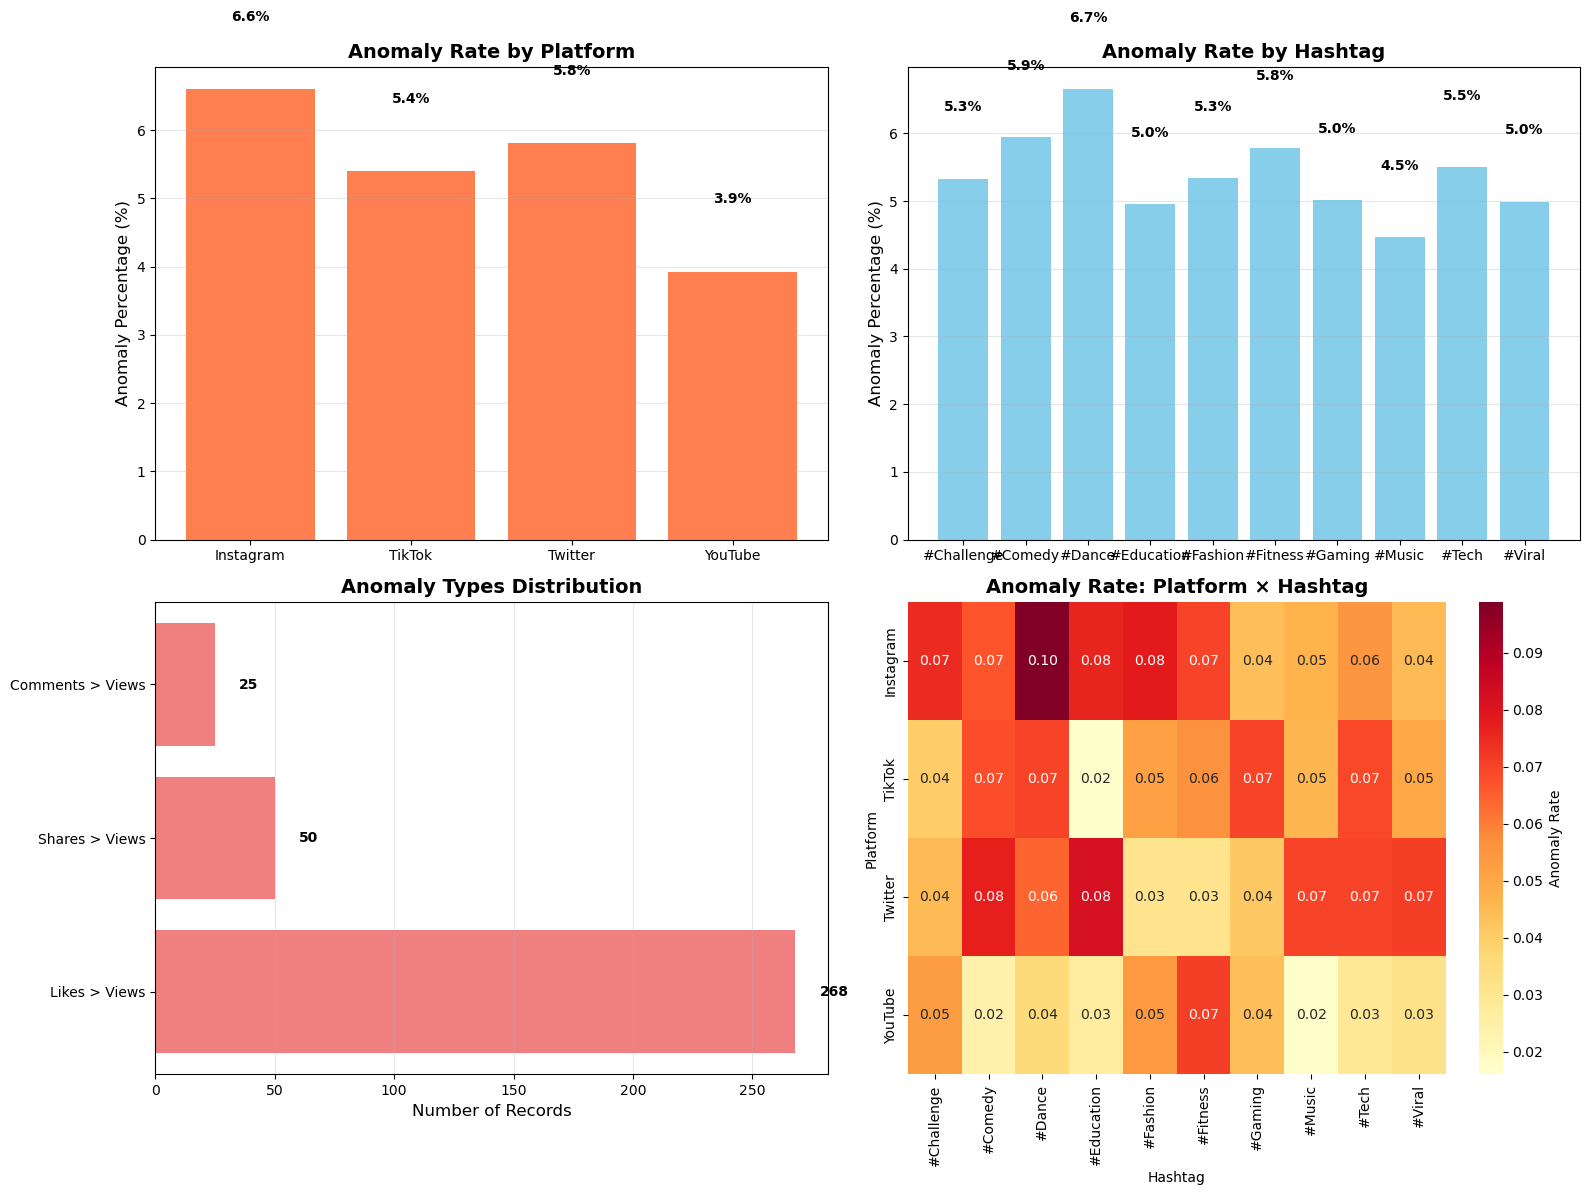


✅ Anomaly analysis visualization saved!


In [829]:

# ========================================
# ANOMALY DETECTION FLAGS (BEFORE SPLIT)
# ========================================

print("\n" + "="*60)
print("STEP 3: Anomaly Flag Creation (Safe - Before Split)")
print("="*60)

# Individual anomaly flags
df_raw['likes_anomaly'] = (df_raw['Likes'] > df_raw['Views']).astype(int)
df_raw['shares_anomaly'] = (df_raw['Shares'] > df_raw['Views']).astype(int)
df_raw['comments_anomaly'] = (df_raw['Comments'] > df_raw['Views']).astype(int)

# Combined anomaly flag
df_raw['any_anomaly'] = ((df_raw['likes_anomaly'] == 1) | 
                     (df_raw['shares_anomaly'] == 1) | 
                     (df_raw['comments_anomaly'] == 1)).astype(int)

# Count anomaly types per record
df_raw['anomaly_count'] = (df_raw['likes_anomaly'] + 
                       df_raw['shares_anomaly'] + 
                       df_raw['comments_anomaly'])

# Anomolies when there are views but 0 likes
df_raw['view_like_anomaly'] = ((df_raw['Views'] > 1000) & (df_raw['Likes'] == 0)).astype(int)

print(f"Likes anomalies: {df_raw['likes_anomaly'].sum()} ({df_raw['likes_anomaly'].mean()*100:.1f}%)")
print(f"Shares anomalies: {df_raw['shares_anomaly'].sum()} ({df_raw['shares_anomaly'].mean()*100:.1f}%)")
print(f"Comments anomalies: {df_raw['comments_anomaly'].sum()} ({df_raw['comments_anomaly'].mean()*100:.1f}%)")
print(f"Any anomaly: {df_raw['any_anomaly'].sum()} ({df_raw['any_anomaly'].mean()*100:.1f}%)")


df_raw.head()

# ========================================
# ANOMALY PATTERN ANALYSIS (EDA)
# ========================================

print("\n" + "="*60)
print("STEP 4: Anomaly Pattern Analysis")
print("="*60)

# Platform analysis
print("\n📊 Anomalies by Platform:")
platform_anomaly = df_raw.groupby('Platform').agg({
    'likes_anomaly': 'sum',
    'shares_anomaly': 'sum',
    'comments_anomaly': 'sum',
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(platform_anomaly)

# Hashtag analysis
print("\n📊 Anomalies by Hashtag:")
hashtag_anomaly = df_raw.groupby('Hashtag').agg({
    'likes_anomaly': 'sum',
    'shares_anomaly': 'sum',
    'comments_anomaly': 'sum',
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(hashtag_anomaly)

# Region analysis
print("\n📊 Anomalies by Region:")
region_anomaly = df_raw.groupby('Region').agg({
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(region_anomaly)

# Cross-analysis: Platform + Hashtag
print("\n📊 Anomalies by Platform × Hashtag:")
cross_analysis = pd.crosstab(
    df_raw['Platform'], 
    df_raw['Hashtag'], 
    values=df_raw['any_anomaly'], 
    aggfunc='mean'
).round(3)
print(cross_analysis)

# ========================================
# VISUALIZATION OF ANOMALY PATTERNS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Anomalies by Platform
platform_counts = df_raw.groupby('Platform')['any_anomaly'].agg(['sum', 'count'])
platform_counts['percentage'] = (platform_counts['sum'] / platform_counts['count'] * 100)
axes[0, 0].bar(platform_counts.index, platform_counts['percentage'], color='coral')
axes[0, 0].set_ylabel('Anomaly Percentage (%)', fontsize=12)
axes[0, 0].set_title('Anomaly Rate by Platform', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(platform_counts['percentage']):
    axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 2: Anomalies by Hashtag
hashtag_counts = df_raw.groupby('Hashtag')['any_anomaly'].agg(['sum', 'count'])
hashtag_counts['percentage'] = (hashtag_counts['sum'] / hashtag_counts['count'] * 100)
axes[0, 1].bar(hashtag_counts.index, hashtag_counts['percentage'], color='skyblue')
axes[0, 1].set_ylabel('Anomaly Percentage (%)', fontsize=12)
axes[0, 1].set_title('Anomaly Rate by Hashtag', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(hashtag_counts['percentage']):
    axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 3: Anomaly type distribution
anomaly_types = pd.DataFrame({
    'Type': ['Likes > Views', 'Shares > Views', 'Comments > Views'],
    'Count': [df_raw['likes_anomaly'].sum(), df_raw['shares_anomaly'].sum(), df_raw['comments_anomaly'].sum()]
})
axes[1, 0].barh(anomaly_types['Type'], anomaly_types['Count'], color='lightcoral')
axes[1, 0].set_xlabel('Number of Records', fontsize=12)
axes[1, 0].set_title('Anomaly Types Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(anomaly_types['Count']):
    axes[1, 0].text(v + 10, i, str(v), va='center', fontweight='bold')

# Plot 4: Heatmap of Platform × Hashtag anomalies
sns.heatmap(cross_analysis, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Anomaly Rate'})
axes[1, 1].set_title('Anomaly Rate: Platform × Hashtag', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'anomaly_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Anomaly analysis visualization saved!")

In [830]:
## Outlier removal - Remove all anomolies 

df_minimal = df_raw.copy()

ANOMALY = ['any_anomaly', 'view_like_anomaly']

# Build a mask of rows to keep (anomaly = 0)
mask = (df_minimal[ANOMALY] == 0).all(axis=1)

# Apply the mask ONCE after building it
df_minimal = df_minimal[mask]

#add time series based columns
df_minimal = add_time_features(df_minimal)

print("✅ Outlier removal complete.")
print(f"Remaining samples in dataset: {len(df_minimal)}")




✅ Outlier removal complete.
Remaining samples in dataset: 4730


### Feature Engineering for Engagement patterns

In [831]:
"""
Feature Engineering to resolve conflicts between views and other metrics,
done before splitting because they do not use statistics"""

print("STEP 2: Feature Engineering (Safe - Before Split)")
print("="*60)

# Basic interaction totals
df_minimal['total_interactions'] = df_minimal['Likes'] + df_minimal['Shares'] + df_minimal['Comments']

# Engagement rates (ratio-based)
df_minimal['engagement_rate'] = df_minimal['Likes'] / (df_minimal['Views'] + 1)
df_minimal['share_rate'] = df_minimal['Shares'] / (df_minimal['Views'] + 1)
df_minimal['comment_rate'] = df_minimal['Comments'] / (df_minimal['Views'] + 1)

# Interaction ratios
df_minimal['likes_per_share'] = df_minimal['Likes'] / (df_minimal['Shares'] + 1)
df_minimal['likes_per_comment'] = df_minimal['Likes'] / (df_minimal['Comments'] + 1)
df_minimal['comment_to_like_ratio'] = df_minimal['Comments'] / (df_minimal['Likes'] + 1)
df_minimal['share_to_like_ratio'] = df_minimal['Shares'] / (df_minimal['Likes'] + 1)

# Virality score (weighted engagement)
df_minimal['virality_score'] = ((df_minimal['Shares'] * 2) + 
                         (df_minimal['Comments'] * 1.5) + 
                         df_minimal['Likes']) / (df_minimal['Views'] + 1)

# Engagement density
df_minimal['engagement_density'] = df_minimal['total_interactions'] / (df_minimal['total_interactions'] + df_minimal['Views'])

# Cap unrealistic ratios
ratio_columns = ['engagement_rate', 'share_rate', 'comment_rate']
for col in ratio_columns:
    df_minimal[col] = df_minimal[col].clip(upper=1.0)

df_minimal['virality_score'] = df_minimal['virality_score'].clip(upper=5.0)

df_minimal.head()




STEP 2: Feature Engineering (Safe - Before Split)


Post_Date   Platform     Hashtag Content_Type     Region    Views   Likes  \
0 2022-01-13     TikTok  #Challenge        Video         UK  4163464  339431   
1 2022-05-13  Instagram  #Education       Shorts      India  4155940  215240   
2 2022-01-07    Twitter  #Challenge        Video     Brazil  3666211  327143   
3 2022-12-05    YouTube  #Education       Shorts  Australia   917951  127125   
5 2022-11-23  Instagram  #Challenge       Shorts  Australia  1323566  136282   

   Shares  Comments Engagement_Level  ...  total_interactions  \
0   53135     19346             High  ...              411912   
1   65860     27239           Medium  ...              308339   
2   39423     36223           Medium  ...              402789   
3   11687     36806              Low  ...              175618   
5   86979     47129              Low  ...              270390   

   engagement_rate  share_rate  comment_rate  likes_per_share  \
0         0.081526    0.012762      0.004647         6.387967   
1         0.051791    0.015847      0.006554         3.268095   
2         0.089232    0.010753      0.009880         8.298067   
3         0.138488    0.012732      0.040096        10.876540   
5         0.102966    0.065716      0.035608         1.566820   

   likes_per_comment  comment_to_like_ratio  share_to_like_ratio  \
0          17.544374               0.056995             0.156541   
1           7.901615               0.126551             0.305983   
2           9.031112               0.110725             0.120507   
3           3.453827               0.289524             0.091932   
5           2.891619               0.345817             0.638223   

   virality_score  engagement_density  
0        0.114020            0.090028  
1        0.093317            0.069068  
2        0.125558            0.098990  
3        0.224095            0.160592  
5        0.287808            0.169635  

[5 rows x 34 columns]

In [832]:
# Check Engagement Level 

df_raw['Engagement_Level'].value_counts(normalize=True)
# This calculated using quantiles method might be imbalanced based on the domain logic

def assign_engagement_level(row):

    engagement_rate = (row['Likes'] + row['Comments'] + row['Shares']) / row['Views']

    # Determine engagement level based on predefined thresholds
    if engagement_rate >= 0.10:  # 10% or higher → High engagement
        return "High"
    elif engagement_rate >= 0.05:  # between 5% and 10% → Medium engagement
        return "Medium"
    else:  # below 5% → Low engagement
        return "Low"

# Apply the function to the dataset to create a new column with calculated engagement levels
df_minimal['Engagement_Level_Cal'] = df_minimal.apply(assign_engagement_level, axis=1)

# Display the first few rows of the modified DataFrame
df_minimal.head()

#This worked perfectly when modelling


Post_Date   Platform     Hashtag Content_Type     Region    Views   Likes  \
0 2022-01-13     TikTok  #Challenge        Video         UK  4163464  339431   
1 2022-05-13  Instagram  #Education       Shorts      India  4155940  215240   
2 2022-01-07    Twitter  #Challenge        Video     Brazil  3666211  327143   
3 2022-12-05    YouTube  #Education       Shorts  Australia   917951  127125   
5 2022-11-23  Instagram  #Challenge       Shorts  Australia  1323566  136282   

   Shares  Comments Engagement_Level  ...  engagement_rate  share_rate  \
0   53135     19346             High  ...         0.081526    0.012762   
1   65860     27239           Medium  ...         0.051791    0.015847   
2   39423     36223           Medium  ...         0.089232    0.010753   
3   11687     36806              Low  ...         0.138488    0.012732   
5   86979     47129              Low  ...         0.102966    0.065716   

   comment_rate  likes_per_share  likes_per_comment  comment_to_like_ratio  \
0      0.004647         6.387967          17.544374               0.056995   
1      0.006554         3.268095           7.901615               0.126551   
2      0.009880         8.298067           9.031112               0.110725   
3      0.040096        10.876540           3.453827               0.289524   
5      0.035608         1.566820           2.891619               0.345817   

   share_to_like_ratio  virality_score  engagement_density  \
0             0.156541        0.114020            0.090028   
1             0.305983        0.093317            0.069068   
2             0.120507        0.125558            0.098990   
3             0.091932        0.224095            0.160592   
5             0.638223        0.287808            0.169635   

   Engagement_Level_Cal  
0                Medium  
1                Medium  
2                  High  
3                  High  
5                  High  

[5 rows x 35 columns]

## Split Train/Test Dataset

In [833]:
# TODO : Refer project brief and claude and make functions 

RAW_METRICS = ['Views', 'Likes', 'Shares', 'Comments']
ENGINEERED_FEATURES = ['share_rate', 'comment_rate', 'likes_per_share',
                         'likes_per_comment', 'comment_to_like_ratio',
                         'share_to_like_ratio', 'virality_score',
                         'engagement_density', 'total_interactions']
NOMINAL_COLS = ['Platform', 'Hashtag', 'Region', 'Content_Type']
ORDINAL_COLS = ['Engagement_Level_Cal']
ORDINAL_CATEGORIES = [['High', 'Medium', 'Low']]
NUMERIC_COLS = RAW_METRICS + ENGINEERED_FEATURES
NUMERIC_COLS_UL = RAW_METRICS + ENGINEERED_FEATURES
ANOMALY_COLS = ['likes_anomaly', 'shares_anomaly', 'comments_anomaly', 'any_anomaly']

feature_cols = NOMINAL_COLS + RAW_METRICS + ['Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year']
targets = RAW_METRICS 
target_cal = ORDINAL_COLS 

X = df_minimal[feature_cols].copy()
y_reg = df_minimal[targets].copy()
y_cal = df_minimal[target_cal].copy()

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

y_train_cal = y_cal.loc[y_train_reg.index]
y_test_cal = y_cal.loc[y_test_reg.index]

print(f"✅ Step 2 complete:")
print(f"   TRAIN: {len(X_train):,} samples")
print(f"   TEST:  {len(X_test):,} samples")
print(f"\n⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY")

print(X_train)
print(X_test)

print(df_raw.columns.tolist())
print(df_minimal.columns.tolist())



✅ Step 2 complete:
   TRAIN: 3,784 samples
   TEST:  946 samples

⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY
       Platform     Hashtag     Region Content_Type    Views   Likes  Shares  \
4688     TikTok       #Tech     Brazil       Shorts   826021   58506   48743   
2572  Instagram  #Education      Japan       Shorts   338623  170174   38826   
840   Instagram     #Comedy     Brazil         Post  4754509  424316   30621   
640   Instagram      #Music    Germany         Post  4892331  362512   17927   
4722    Twitter     #Gaming    Germany       Shorts  3399161  424575   33841   
...         ...         ...        ...          ...      ...     ...     ...   
4671    Twitter       #Tech        USA        Tweet  4409288  179602   85822   
493      TikTok      #Dance  Australia         Post   797705  102013   63301   
3270     TikTok  #Challenge      India         Reel  1499889  478518   92766   
3980    Twitter  #Challenge        USA         Reel  4332749  1744

## Handle Outliers

In [834]:

# TODO: Implement found outliers bool

found  = True
for col in y_train_reg.columns:


    lower, upper = calculate_iqr_bounds(y_train_reg[col], IQR_MULTIPLIER)
    print(f"IQR bounds (from TRAIN): {lower:.2f} to {upper:.2f}")

    # Count outliers
    train_outliers = ((y_train_reg[col] < lower) | (y_train_reg[col] > upper)).sum()
    test_outliers = ((y_test_reg[col] < lower) | (y_test_reg[col] > upper)).sum()
    print(f"Outliers detected: TRAIN={train_outliers:,}, TEST={test_outliers:,}")
    
    # Remove outliers from TRAIN
    mask_train = (y_train_reg[col] >= lower) & (y_train_reg[col] <= upper) # Returns a boolean mask
    X_train = X_train[mask_train] # Apply mask to X_train, all false rows are removed
    y_train = y_train_reg[mask_train] 

    # Apply same bounds to TEST
    mask_test = (y_test_reg[col] >= lower) & (y_test_reg[col] <= upper)
    X_test = X_test[mask_test]
    y_test = y_test_reg[mask_test]

    print(f"\n✅ Outlier detection for {col} complete:")
    print(f"   TRAIN: {len(X_train):,} samples")
    print(f"   TEST:  {len(X_test):,} samples")



IQR bounds (from TRAIN): -2200459.75 to 7405428.25
Outliers detected: TRAIN=0, TEST=0

✅ Outlier detection for Views complete:
   TRAIN: 3,784 samples
   TEST:  946 samples
IQR bounds (from TRAIN): -243265.62 to 736817.38
Outliers detected: TRAIN=0, TEST=0

✅ Outlier detection for Likes complete:
   TRAIN: 3,784 samples
   TEST:  946 samples
IQR bounds (from TRAIN): -51091.12 to 151875.88
Outliers detected: TRAIN=0, TEST=0

✅ Outlier detection for Shares complete:
   TRAIN: 3,784 samples
   TEST:  946 samples
IQR bounds (from TRAIN): -24771.62 to 74055.38
Outliers detected: TRAIN=0, TEST=0

✅ Outlier detection for Comments complete:
   TRAIN: 3,784 samples
   TEST:  946 samples


In [835]:
X_train.head()


Platform     Hashtag   Region Content_Type    Views   Likes  Shares  \
4688     TikTok       #Tech   Brazil       Shorts   826021   58506   48743   
2572  Instagram  #Education    Japan       Shorts   338623  170174   38826   
840   Instagram     #Comedy   Brazil         Post  4754509  424316   30621   
640   Instagram      #Music  Germany         Post  4892331  362512   17927   
4722    Twitter     #Gaming  Germany       Shorts  3399161  424575   33841   

      Comments  Post_Date  day_of_week  is_weekend  day_of_month  month  \
4688     43924 2023-01-22            6           1            22      1   
2572     10092 2023-10-28            5           1            28     10   
840      18374 2022-10-28            4           0            28     10   
640      27598 2022-09-12            0           0            12      9   
4722     15840 2022-07-31            6           1            31      7   

      quarter  week_of_year  day_of_year  
4688        1             3           22  
2572        4            43          301  
840         4            43          301  
640         3            37          255  
4722        3            30          212

In [836]:
X_test.head()

Platform   Hashtag     Region Content_Type    Views   Likes  Shares  \
4159  Instagram    #Dance         UK         Reel  4356395  367535   89909   
2853    YouTube    #Viral  Australia        Video   540884  177369   13503   
240     YouTube    #Viral      India       Shorts   920528  400658   58158   
1335    YouTube  #Fashion      Japan  Live Stream  4610463  425376   84697   
2825    Twitter   #Comedy        USA        Video  4533943  426510   48183   

      Comments  Post_Date  day_of_week  is_weekend  day_of_month  month  \
4159     10900 2022-08-04            3           0             4      8   
2853      5565 2022-02-02            2           0             2      2   
240      26810 2022-10-29            5           1            29     10   
1335     14385 2023-06-26            0           0            26      6   
2825      8972 2023-06-15            3           0            15      6   

      quarter  week_of_year  day_of_year  
4159        3            31          216  
2853        1             5           33  
240         4            43          302  
1335        2            26          177  
2825        2            24          166

## Feature Engineering for Model Peformance

### Average features for core metrics

In [837]:
"""
The included features are not sufficient for model training as they contain only categorical variables 
we cant include other core metrics or other engineered features they will cause data leaks.

"""
print("\n" + "="*60)
print("Feature engineering for optimal model performance")
print("="*60)

# Compute averages on training set only

print("Computing average-based features from TRAIN set...")
print("*"*60)

print("Calculating average views per categorical variable...")
# 1. Average Views per Hashtag
avg_views_hashtag = X_train.groupby("Hashtag")["Views"].mean()
X_train["Hashtag_Avg_Views"] = X_train["Hashtag"].map(avg_views_hashtag)
X_test["Hashtag_Avg_Views"] = X_test["Hashtag"].map(avg_views_hashtag)

# 2. Average Views per Platform
avg_views_platform = X_train.groupby("Platform")["Views"].mean()
X_train["Platform_Avg_Views"] = X_train["Platform"].map(avg_views_platform)
X_test["Platform_Avg_Views"] = X_test["Platform"].map(avg_views_platform)

# 3. Average views per Region
avg_views_region = X_train.groupby("Region")["Views"].mean()
X_train["Region_Avg_Views"] = X_train["Region"].map(avg_views_region)
X_test["Region_Avg_Views"] = X_test["Region"].map(avg_views_region)

# 4. Content Type Average Views
avg_views_content = X_train.groupby("Content_Type")["Views"].mean()
X_train["ContentType_Avg_Views"] = X_train["Content_Type"].map(avg_views_content)
X_test["ContentType_Avg_Views"] = X_test["Content_Type"].map(avg_views_content)

print ("Feature: Hashtag_Avg_Views, Platform_Avg_Views, Region_Avg_Views, ContentType_Avg_Views added successfully.")

print("Calculating average Likes per categorical variable...")

# 1. Average Likes per Hashtag
avg_likes_hashtag = X_train.groupby("Hashtag")["Likes"].mean()
X_train["Hashtag_Avg_Likes"] = X_train["Hashtag"].map(avg_likes_hashtag)
X_test["Hashtag_Avg_Likes"] = X_test["Hashtag"].map(avg_likes_hashtag)

# 2. Average Likes per Platform
avg_likes_platform = X_train.groupby("Platform")["Likes"].mean()
X_train["Platform_Avg_Likes"] = X_train["Platform"].map(avg_likes_platform)
X_test["Platform_Avg_Likes"] = X_test["Platform"].map(avg_likes_platform)

# 3. Average Likes per Region
avg_likes_region = X_train.groupby("Region")["Likes"].mean()
X_train["Region_Avg_Likes"] = X_train["Region"].map(avg_likes_region)
X_test["Region_Avg_Likes"] = X_test["Region"].map(avg_likes_region)

# 4. Average Likes per Content Type
avg_likes_content = X_train.groupby("Content_Type")["Likes"].mean()
X_train["ContentType_Avg_Likes"] = X_train["Content_Type"].map(avg_likes_content)
X_test["ContentType_Avg_Likes"] = X_test["Content_Type"].map(avg_likes_content)

print("Feature: Hashtag_Avg_Likes, Platform_Avg_Likes, Region_Avg_Likes, ContentType_Avg_Likes added successfully.")


print("Calculating average Shares per categorical variable...")

# 1. Average Shares per Hashtag
avg_shares_hashtag = X_train.groupby("Hashtag")["Shares"].mean()
X_train["Hashtag_Avg_Shares"] = X_train["Hashtag"].map(avg_shares_hashtag)
X_test["Hashtag_Avg_Shares"] = X_test["Hashtag"].map(avg_shares_hashtag)

# 2. Average Shares per Platform
avg_shares_platform = X_train.groupby("Platform")["Shares"].mean()
X_train["Platform_Avg_Shares"] = X_train["Platform"].map(avg_shares_platform)
X_test["Platform_Avg_Shares"] = X_test["Platform"].map(avg_shares_platform)

# 3. Average Shares per Region
avg_shares_region = X_train.groupby("Region")["Shares"].mean()
X_train["Region_Avg_Shares"] = X_train["Region"].map(avg_shares_region)
X_test["Region_Avg_Shares"] = X_test["Region"].map(avg_shares_region)

# 4. Average Shares per Content Type
avg_shares_content = X_train.groupby("Content_Type")["Shares"].mean()
X_train["ContentType_Avg_Shares"] = X_train["Content_Type"].map(avg_shares_content)
X_test["ContentType_Avg_Shares"] = X_test["Content_Type"].map(avg_shares_content)

print("Feature: Hashtag_Avg_Shares, Platform_Avg_Shares, Region_Avg_Shares, ContentType_Avg_Shares added successfully.")


print("Calculating average Comments per categorical variable...")

# 1. Average Comments per Hashtag
avg_comments_hashtag = X_train.groupby("Hashtag")["Comments"].mean()
X_train["Hashtag_Avg_Comments"] = X_train["Hashtag"].map(avg_comments_hashtag)
X_test["Hashtag_Avg_Comments"] = X_test["Hashtag"].map(avg_comments_hashtag)

# 2. Average Comments per Platform
avg_comments_platform = X_train.groupby("Platform")["Comments"].mean()
X_train["Platform_Avg_Comments"] = X_train["Platform"].map(avg_comments_platform)
X_test["Platform_Avg_Comments"] = X_test["Platform"].map(avg_comments_platform)

# 3. Average Comments per Region
avg_comments_region = X_train.groupby("Region")["Comments"].mean()
X_train["Region_Avg_Comments"] = X_train["Region"].map(avg_comments_region)
X_test["Region_Avg_Comments"] = X_test["Region"].map(avg_comments_region)

# 4. Average Comments per Content Type
avg_comments_content = X_train.groupby("Content_Type")["Comments"].mean()
X_train["ContentType_Avg_Comments"] = X_train["Content_Type"].map(avg_comments_content)
X_test["ContentType_Avg_Comments"] = X_test["Content_Type"].map(avg_comments_content)

print("Feature: Hashtag_Avg_Comments, Platform_Avg_Comments, Region_Avg_Comments, ContentType_Avg_Comments added successfully.")





Feature engineering for optimal model performance
Computing average-based features from TRAIN set...
************************************************************
Calculating average views per categorical variable...
Feature: Hashtag_Avg_Views, Platform_Avg_Views, Region_Avg_Views, ContentType_Avg_Views added successfully.
Calculating average Likes per categorical variable...
Feature: Hashtag_Avg_Likes, Platform_Avg_Likes, Region_Avg_Likes, ContentType_Avg_Likes added successfully.
Calculating average Shares per categorical variable...
Feature: Hashtag_Avg_Shares, Platform_Avg_Shares, Region_Avg_Shares, ContentType_Avg_Shares added successfully.
Calculating average Comments per categorical variable...
Feature: Hashtag_Avg_Comments, Platform_Avg_Comments, Region_Avg_Comments, ContentType_Avg_Comments added successfully.


### Posts count based on the Median

In [838]:
# Compute medians for each metric in the training set
median_views = X_train["Views"].median()
median_likes = X_train["Likes"].median()
median_shares = X_train["Shares"].median()
median_comments = X_train["Comments"].median()

print("Calculating count-based features from TRAIN set...")
print("*"*60)
# 
# Views
X_train["Views_Above_Median"] = (X_train["Views"] > median_views).astype(int)
X_test["Views_Above_Median"] = (X_test["Views"] > median_views).astype(int)

# Likes
X_train["Likes_Above_Median"] = (X_train["Likes"] > median_likes).astype(int)
X_test["Likes_Above_Median"] = (X_test["Likes"] > median_likes).astype(int)

# Shares
X_train["Shares_Above_Median"] = (X_train["Shares"] > median_shares).astype(int)
X_test["Shares_Above_Median"] = (X_test["Shares"] > median_shares).astype(int)

# Comments
X_train["Comments_Above_Median"] = (X_train["Comments"] > median_comments).astype(int)
X_test["Comments_Above_Median"] = (X_test["Comments"] > median_comments).astype(int)

print("Calculating the summary counts")
# Views
views_above_hashtag = X_train.groupby("Hashtag")["Views_Above_Median"].sum()
X_train["Hashtag_Views_Above_Median_Count"] = X_train["Hashtag"].map(views_above_hashtag)
X_test["Hashtag_Views_Above_Median_Count"] = X_test["Hashtag"].map(views_above_hashtag)

views_below_hashtag = X_train.groupby("Hashtag")["Views_Above_Median"].count() - views_above_hashtag
X_train["Hashtag_Views_Below_Median_Count"] = X_train["Hashtag"].map(views_below_hashtag)
X_test["Hashtag_Views_Below_Median_Count"] = X_test["Hashtag"].map(views_below_hashtag)

# Likes
likes_above_hashtag = X_train.groupby("Hashtag")["Likes_Above_Median"].sum()
X_train["Hashtag_Likes_Above_Median_Count"] = X_train["Hashtag"].map(likes_above_hashtag)
X_test["Hashtag_Likes_Above_Median_Count"] = X_test["Hashtag"].map(likes_above_hashtag)

likes_below_hashtag = X_train.groupby("Hashtag")["Likes_Above_Median"].count() - likes_above_hashtag
X_train["Hashtag_Likes_Below_Median_Count"] = X_train["Hashtag"].map(likes_below_hashtag)
X_test["Hashtag_Likes_Below_Median_Count"] = X_test["Hashtag"].map(likes_below_hashtag)

# Shares
shares_above_hashtag = X_train.groupby("Hashtag")["Shares_Above_Median"].sum()
X_train["Hashtag_Shares_Above_Median_Count"] = X_train["Hashtag"].map(shares_above_hashtag)
X_test["Hashtag_Shares_Above_Median_Count"] = X_test["Hashtag"].map(shares_above_hashtag)

shares_below_hashtag = X_train.groupby("Hashtag")["Shares_Above_Median"].count() - shares_above_hashtag
X_train["Hashtag_Shares_Below_Median_Count"] = X_train["Hashtag"].map(shares_below_hashtag)
X_test["Hashtag_Shares_Below_Median_Count"] = X_test["Hashtag"].map(shares_below_hashtag)   

# Comments
comments_above_hashtag = X_train.groupby("Hashtag")["Comments_Above_Median"].sum()
X_train["Hashtag_Comments_Above_Median_Count"] = X_train["Hashtag"].map(comments_above_hashtag)
X_test["Hashtag_Comments_Above_Median_Count"] = X_test["Hashtag"].map(comments_above_hashtag)   

comments_below_hashtag = X_train.groupby("Hashtag")["Comments_Above_Median"].count() - comments_above_hashtag
X_train["Hashtag_Comments_Below_Median_Count"] = X_train["Hashtag"].map(comments_below_hashtag)
X_test["Hashtag_Comments_Below_Median_Count"] = X_test["Hashtag"].map(comments_below_hashtag)   

print("Count-based features added successfully.")



Calculating count-based features from TRAIN set...
************************************************************
Calculating the summary counts
Count-based features added successfully.


## Calculating Z-scores

In [839]:

print("Calculating z-scores for all core metrics...")

# ------------------------------
# Views z-score per category
views_stats_hashtag = X_train.groupby("Hashtag")["Views"].agg(['mean','std']).to_dict()
X_train["Views_Z_Hashtag"] = (X_train["Views"] - X_train["Hashtag"].map(views_stats_hashtag['mean'])) / X_train["Hashtag"].map(views_stats_hashtag['std'])
X_test["Views_Z_Hashtag"] = (X_test["Views"] - X_test["Hashtag"].map(views_stats_hashtag['mean'])) / X_test["Hashtag"].map(views_stats_hashtag['std'])

# Views z-score per Platform
views_stats_platform = X_train.groupby("Platform")["Views"].agg(['mean','std']).to_dict()
X_train["Views_Z_Platform"] = (X_train["Views"] - X_train["Platform"].map(views_stats_platform['mean'])) / X_train["Platform"].map(views_stats_platform['std'])
X_test["Views_Z_Platform"] = (X_test["Views"] - X_test["Platform"].map(views_stats_platform['mean'])) / X_test["Platform"].map(views_stats_platform['std'])

# Views z-score per Region
views_stats_region = X_train.groupby("Region")["Views"].agg(['mean','std']).to_dict()
X_train["Views_Z_Region"] = (X_train["Views"] - X_train["Region"].map(views_stats_region['mean'])) / X_train["Region"].map(views_stats_region['std'])
X_test["Views_Z_Region"] = (X_test["Views"] - X_test["Region"].map(views_stats_region['mean'])) / X_test["Region"].map(views_stats_region['std'])

# Views z-score per Content Type
views_stats_content = X_train.groupby("Content_Type")["Views"].agg(['mean','std']).to_dict()
X_train["Views_Z_ContentType"] = (X_train["Views"] - X_train["Content_Type"].map(views_stats_content['mean'])) / X_train["Content_Type"].map(views_stats_content['std'])

X_test["Views_Z_ContentType"] = (X_test["Views"] - X_test["Content_Type"].map(views_stats_content['mean'])) / X_test["Content_Type"].map(views_stats_content['std'])

print("Views z-scores added successfully.")

# ------------------------------

# Likes
likes_stats_hashtag = X_train.groupby("Hashtag")["Likes"].agg(['mean','std']).to_dict()
X_train["Likes_Z_Hashtag"] = (X_train["Likes"] - X_train["Hashtag"].map(likes_stats_hashtag['mean'])) / X_train["Hashtag"].map(likes_stats_hashtag['std'])
X_test["Likes_Z_Hashtag"] = (X_test["Likes"] - X_test["Hashtag"].map(likes_stats_hashtag['mean'])) / X_test["Hashtag"].map(likes_stats_hashtag['std'])

likes_stats_platform = X_train.groupby("Platform")["Likes"].agg(['mean','std']).to_dict()
X_train["Likes_Z_Platform"] = (X_train["Likes"] - X_train["Platform"].map(likes_stats_platform['mean'])) / X_train["Platform"].map(likes_stats_platform['std'])
X_test["Likes_Z_Platform"] = (X_test["Likes"] - X_test["Platform"].map(likes_stats_platform['mean'])) / X_test["Platform"].map(likes_stats_platform['std'])

likes_stats_region = X_train.groupby("Region")["Likes"].agg(['mean','std']).to_dict()
X_train["Likes_Z_Region"] = (X_train["Likes"] - X_train["Region"].map(likes_stats_region['mean'])) / X_train["Region"].map(likes_stats_region['std'])
X_test["Likes_Z_Region"] = (X_test["Likes"] - X_test["Region"].map(likes_stats_region['mean'])) / X_test["Region"].map(likes_stats_region['std'])

likes_stats_content = X_train.groupby("Content_Type")["Likes"].agg(['mean','std']).to_dict()
X_train["Likes_Z_ContentType"] = (X_train["Likes"] - X_train["Content_Type"].map(likes_stats_content['mean'])) / X_train["Content_Type"].map(likes_stats_content['std'])
X_test["Likes_Z_ContentType"] = (X_test["Likes"] - X_test["Content_Type"].map(likes_stats_content['mean'])) / X_test["Content_Type"].map(likes_stats_content['std'])

print("Likes z-scores added successfully.")

# ------------------------------
# Shares
shares_stats_hashtag = X_train.groupby("Hashtag")["Shares"].agg(['mean','std']).to_dict()
X_train["Shares_Z_Hashtag"] = (X_train["Shares"] - X_train["Hashtag"].map(shares_stats_hashtag['mean'])) / X_train["Hashtag"].map(shares_stats_hashtag['std'])
X_test["Shares_Z_Hashtag"] = (X_test["Shares"] - X_test["Hashtag"].map(shares_stats_hashtag['mean'])) / X_test["Hashtag"].map(shares_stats_hashtag['std'])

shares_stats_platform = X_train.groupby("Platform")["Shares"].agg(['mean','std']).to_dict()
X_train["Shares_Z_Platform"] = (X_train["Shares"] - X_train["Platform"].map(shares_stats_platform['mean'])) / X_train["Platform"].map(shares_stats_platform['std'])
X_test["Shares_Z_Platform"] = (X_test["Shares"] - X_test["Platform"].map(shares_stats_platform['mean'])) / X_test["Platform"].map(shares_stats_platform['std'])

shares_stats_region = X_train.groupby("Region")["Shares"].agg(['mean','std']).to_dict()
X_train["Shares_Z_Region"] = (X_train["Shares"] - X_train["Region"].map(shares_stats_region['mean'])) / X_train["Region"].map(shares_stats_region['std'])
X_test["Shares_Z_Region"] = (X_test["Shares"] - X_test["Region"].map(shares_stats_region['mean'])) / X_test["Region"].map(shares_stats_region['std'])

shares_stats_content = X_train.groupby("Content_Type")["Shares"].agg(['mean','std']).to_dict()
X_train["Shares_Z_ContentType"] = (X_train["Shares"] - X_train["Content_Type"].map(shares_stats_content['mean'])) / X_train["Content_Type"].map(shares_stats_content['std'])
X_test["Shares_Z_ContentType"] = (X_test["Shares"] - X_test["Content_Type"].map(shares_stats_content['mean'])) / X_test["Content_Type"].map(shares_stats_content['std'])

print("Shares z-scores added successfully.")

# ------------------------------
# Comments
comments_stats_hashtag = X_train.groupby("Hashtag")["Comments"].agg(['mean','std']).to_dict()
X_train["Comments_Z_Hashtag"] = (X_train["Comments"] - X_train["Hashtag"].map(comments_stats_hashtag['mean'])) / X_train["Hashtag"].map(comments_stats_hashtag['std'])
X_test["Comments_Z_Hashtag"] = (X_test["Comments"] - X_test["Hashtag"].map(comments_stats_hashtag['mean'])) / X_test["Hashtag"].map(comments_stats_hashtag['std'])

comments_stats_platform = X_train.groupby("Platform")["Comments"].agg(['mean','std']).to_dict()
X_train["Comments_Z_Platform"] = (X_train["Comments"] - X_train["Platform"].map(comments_stats_platform['mean'])) / X_train["Platform"].map(comments_stats_platform['std'])
X_test["Comments_Z_Platform"] = (X_test["Comments"] - X_test["Platform"].map(comments_stats_platform['mean'])) / X_test["Platform"].map(comments_stats_platform['std'])

comments_stats_region = X_train.groupby("Region")["Comments"].agg(['mean','std']).to_dict()
X_train["Comments_Z_Region"] = (X_train["Comments"] - X_train["Region"].map(comments_stats_region['mean'])) / X_train["Region"].map(comments_stats_region['std'])
X_test["Comments_Z_Region"] = (X_test["Comments"] - X_test["Region"].map(comments_stats_region['mean'])) / X_test["Region"].map(comments_stats_region['std'])

comments_stats_content = X_train.groupby("Content_Type")["Comments"].agg(['mean','std']).to_dict()
X_train["Comments_Z_ContentType"] = (X_train["Comments"] - X_train["Content_Type"].map(comments_stats_content['mean'])) / X_train["Content_Type"].map(comments_stats_content['std'])
X_test["Comments_Z_ContentType"] = (X_test["Comments"] - X_test["Content_Type"].map(comments_stats_content['mean'])) / X_test["Content_Type"].map(comments_stats_content['std'])

print("Comments z-scores added successfully.")


Calculating z-scores for all core metrics...
Views z-scores added successfully.
Likes z-scores added successfully.
Shares z-scores added successfully.
Comments z-scores added successfully.


## Feature Binning for Better Classification Performance

In [840]:
# metrics = ['Views', 'Likes', 'Shares', 'Comments']

# for metric in metrics:
#     # Compute training quantiles
#     quantiles = X_train[metric].quantile([0.33, 0.66])
    
#     # Create class labels based on training quantiles
#     X_train[f'{metric}_Class'] = pd.cut(
#         X_train[metric],
#         bins=[-float('inf'), quantiles[0.33], quantiles[0.66], float('inf')],
#         labels=['Low', 'Medium', 'High']
#     )
    
#     X_test[f'{metric}_Class'] = pd.cut(
#         X_test[metric],
#         bins=[-float('inf'), quantiles[0.33], quantiles[0.66], float('inf')],
#         labels=['Low', 'Medium', 'High']
#     )

# # Optional: check distribution
# for metric in metrics:
#     print(f"{metric} Class Distribution (Train):\n", X_train[f'{metric}_Class'].value_counts())
#     print(f"{metric} Class Distribution (Test):\n", X_test[f'{metric}_Class'].value_counts(), "\n")
    
    
    
# ORDINAL_COLS_CLS = ['Views_Class', 'Likes_Class', 'Shares_Class', 'Comments_Class']
# ORDINAL_CATEGORIES_CLS = [
#     ['Low','Medium','High'],  # Views_Class
#     ['Low','Medium','High'],  # Likes_Class
#     ['Low','Medium','High'],  # Shares_Class
#     ['Low','Medium','High']   # Comments_Class
# ]

# TODO : See if this feature contributes to model performance

### Frequency Features

In [841]:
# How common each feature is in the dataset
hashtag_freq = X_train["Hashtag"].value_counts()
platform_freq = X_train["Platform"].value_counts()
region_freq = X_train["Region"].value_counts()
contenttype_freq = X_train["Content_Type"].value_counts()

# ------ MAP TO TRAIN ------
X_train["Hashtag_Frequency"] = X_train["Hashtag"].map(hashtag_freq)
X_train["Platform_Frequency"] = X_train["Platform"].map(platform_freq)
X_train["Region_Frequency"] = X_train["Region"].map(region_freq)
X_train["ContentType_Frequency"] = X_train["Content_Type"].map(contenttype_freq)

# ------ MAP TO TEST (NO LEAKAGE) ------
X_test["Hashtag_Frequency"] = X_test["Hashtag"].map(hashtag_freq)
X_test["Platform_Frequency"] = X_test["Platform"].map(platform_freq)
X_test["Region_Frequency"] = X_test["Region"].map(region_freq)
X_test["ContentType_Frequency"] = X_test["Content_Type"].map(contenttype_freq)

### Time Based Features

In [842]:
X_train['Post_Date'] = pd.to_datetime(X_train['Post_Date'])
X_test['Post_Date'] = pd.to_datetime(X_test['Post_Date'])


# Days since the earliest post in the training set
earliest_date = X_train['Post_Date'].min()
latest_date = X_train['Post_Date'].max()

X_train['days_since_first_post'] = (X_train['Post_Date'] - earliest_date).dt.days
X_test['days_since_first_post'] = (X_test['Post_Date'] - earliest_date).dt.days

# Optional: days until last post (can capture recency effect)
X_train['days_until_last_post'] = (latest_date - X_train['Post_Date']).dt.days
X_test['days_until_last_post'] = (latest_date - X_test['Post_Date']).dt.days


### Average core metrics per month

In [ ]:
avg_views_per_month = X_train.groupby('year_month')['Views'].mean()
X_train['views_per_month'] = X_train['year_month'].map(avg_views_per_month)
X_test['views_per_month'] = X_test['year_month'].map(avg_views_per_month)

avg_likes_per_month = X_train.groupby('year_month')['Likes'].mean()
X_train['likes_per_month'] = X_train['year_month'].map(avg_likes_per_month)
X_test['likes_per_month'] = X_test['year_month'].map(avg_likes_per_month)

avg_shares_per_month = X_train.groupby('year_month')['Shares'].mean()
X_train['shares_per_month'] = X_train['year_month'].map(avg_shares_per_month)
X_test['shares_per_month'] = X_test['year_month'].map(avg_shares_per_month)

avg_comments_per_month = X_train.groupby('year_month')['Comments'].mean()
X_train['comments_per_month'] = X_train['year_month'].map(avg_comments_per_month)
X_test['comments_per_month'] = X_test['year_month'].map(avg_comments_per_month)

In [843]:



#Extend the Numeric cols to include new features
NUMERIC_COLS.extend(['Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'ContentType_Avg_Views', 'Hashtag_Avg_Likes',
                           'Platform_Avg_Likes', 'Region_Avg_Likes', 'ContentType_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares',
                           'Region_Avg_Shares', 'ContentType_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments',
                           'Views_Z_Hashtag', 'Views_Z_Platform', 'Views_Z_Region', 'Views_Z_ContentType',
                           'Likes_Z_Hashtag', 'Likes_Z_Platform', 'Likes_Z_Region', 'Likes_Z_ContentType',
                           'Shares_Z_Hashtag', 'Shares_Z_Platform', 'Shares_Z_Region', 'Shares_Z_ContentType',
                           'Comments_Z_Hashtag', 'Comments_Z_Platform', 'Comments_Z_Region', 'Comments_Z_ContentType', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post'])

In [844]:
X_train.head()

Platform     Hashtag   Region Content_Type    Views   Likes  Shares  \
4688     TikTok       #Tech   Brazil       Shorts   826021   58506   48743   
2572  Instagram  #Education    Japan       Shorts   338623  170174   38826   
840   Instagram     #Comedy   Brazil         Post  4754509  424316   30621   
640   Instagram      #Music  Germany         Post  4892331  362512   17927   
4722    Twitter     #Gaming  Germany       Shorts  3399161  424575   33841   

      Comments  Post_Date  day_of_week  ...  Comments_Z_Hashtag  \
4688     43924 2023-01-22            6  ...            1.233473   
2572     10092 2023-10-28            5  ...           -1.019129   
840      18374 2022-10-28            4  ...           -0.494803   
640      27598 2022-09-12            0  ...            0.172879   
4722     15840 2022-07-31            6  ...           -0.679914   

      Comments_Z_Platform  Comments_Z_Region  Comments_Z_ContentType  \
4688             1.329120           1.346211                1.261701   
2572            -1.046622          -1.053497               -1.003723   
840             -0.452860          -0.415450               -0.413657   
640              0.208437           0.189946                0.227282   
4722            -0.585598          -0.630072               -0.618832   

      Hashtag_Frequency  Platform_Frequency  Region_Frequency  \
4688                375                 963               477   
2572                415                 895               464   
840                 374                 895               477   
640                 373                 895               439   
4722                342                 909               439   

      ContentType_Frequency  days_since_first_post  days_until_last_post  
4688                    601                    386                   342  
2572                    601                    665                    63  
840                     639                    300                   428  
640                     639                    254                   474  
4722                    601                    211                   517  

[5 rows x 66 columns]

In [845]:
y_train.head()

Views   Likes  Shares  Comments
4688   826021   58506   48743     43924
2572   338623  170174   38826     10092
840   4754509  424316   30621     18374
640   4892331  362512   17927     27598
4722  3399161  424575   33841     15840

In [846]:
y_train.head()

Views   Likes  Shares  Comments
4688   826021   58506   48743     43924
2572   338623  170174   38826     10092
840   4754509  424316   30621     18374
640   4892331  362512   17927     27598
4722  3399161  424575   33841     15840

## Correalation Matrix


Correlation matrix
                          Views     Likes    Shares  Comments  day_of_week  \
Views                  1.000000  0.051181  0.023620  0.005989     0.009140   
Likes                  0.051181  1.000000  0.011566 -0.012563    -0.024248   
Shares                 0.023620  0.011566  1.000000  0.010622     0.032281   
Comments               0.005989 -0.012563  0.010622  1.000000     0.014869   
day_of_week            0.009140 -0.024248  0.032281  0.014869     1.000000   
...                         ...       ...       ...       ...          ...   
Platform_Frequency     0.025415  0.013781 -0.015164  0.019557    -0.025615   
Region_Frequency       0.023284  0.006735  0.006082  0.008726     0.015065   
ContentType_Frequency -0.005160  0.008504 -0.001362  0.006137     0.004081   
days_since_first_post  0.013790  0.008578 -0.000001 -0.004217    -0.019922   
days_until_last_post  -0.013790 -0.008578  0.000001  0.004217     0.019922   

                       is_weekend  day_of_m

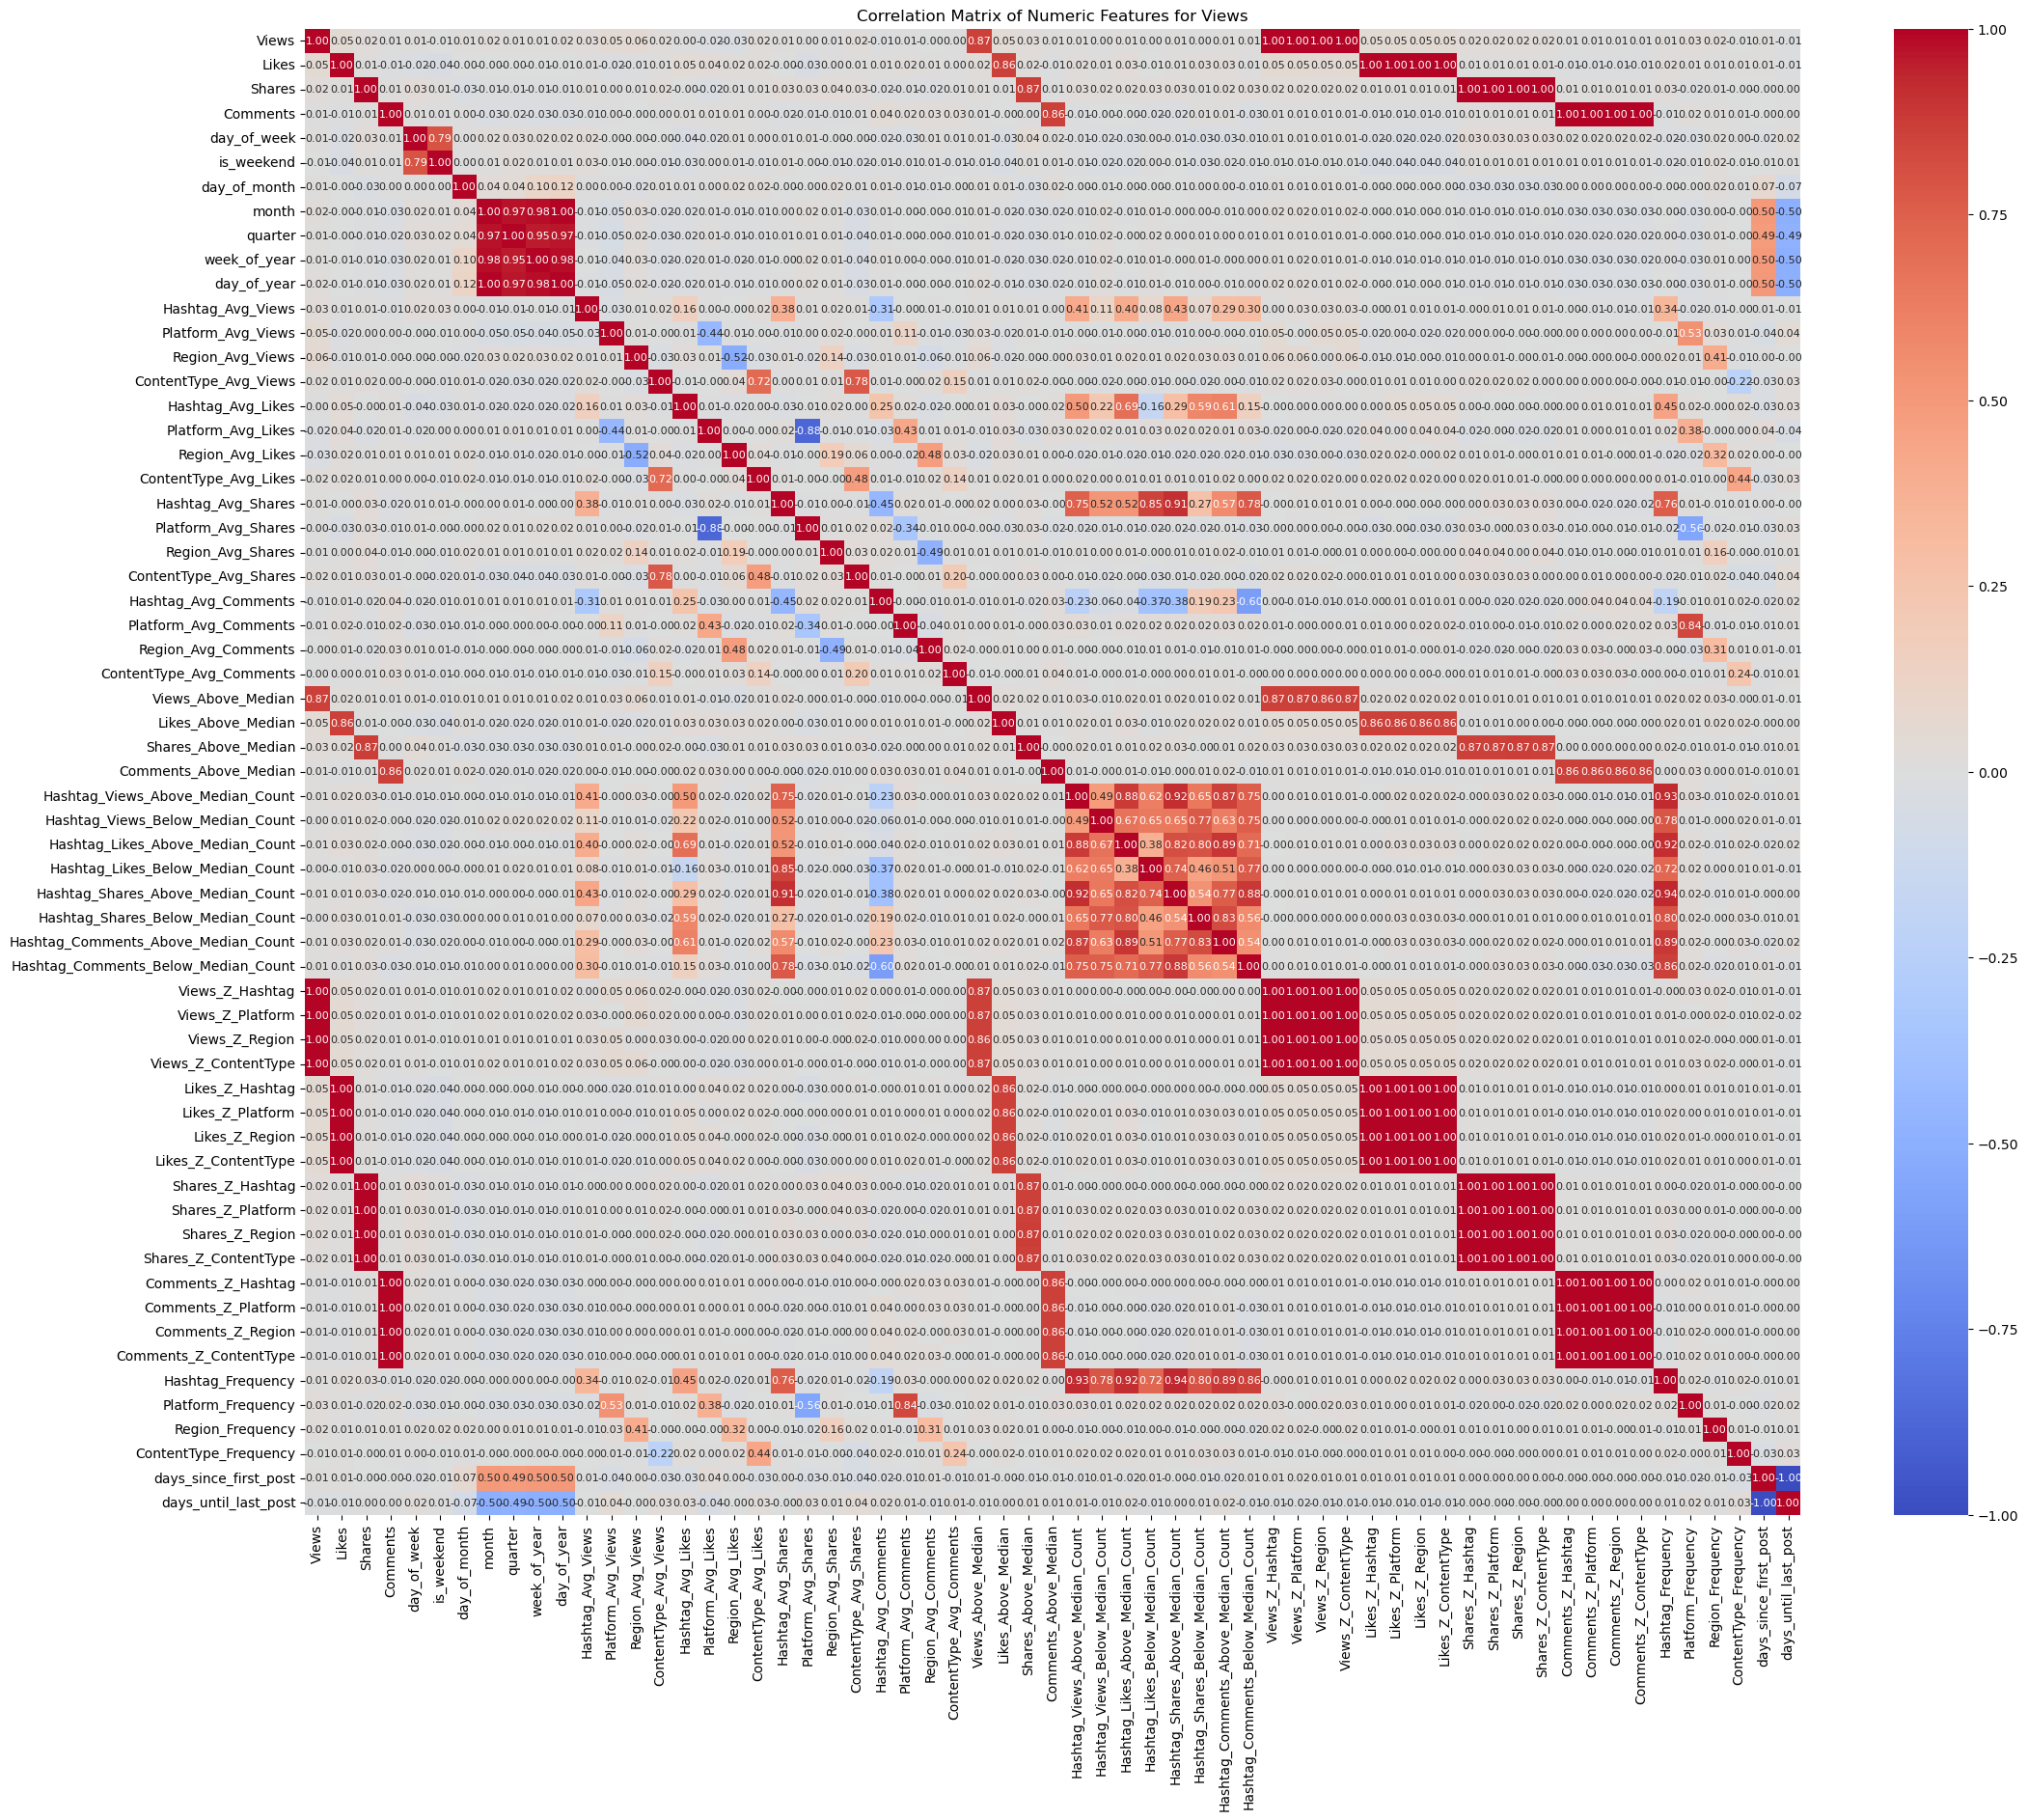

In [847]:


num_cols = X_train.select_dtypes(include='number').columns.tolist()

# Include the target in the correlation analysis
num_data = X_train[num_cols].copy()
# num_data['Views'] = y_train['Views']

# Compute correlation matrix
correlation_matrix = num_data.corr()
print(f"\nCorrelation matrix")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(25, 20))  # width x height
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
        cbar=True, annot_kws={"size": 8})  # annotation font size
plt.xticks(rotation=90, fontsize=10)  # x-axis labels
plt.yticks(rotation=0, fontsize=10)   # y-axis labels
plt.title(f"Correlation Matrix of Numeric Features for Views")
plt.savefig(FIGURES_DIR / f'Corelation-matrix.png', dpi=150, bbox_inches='tight')
plt.savefig
plt.show()

In [848]:
y_train_reg.head()

Views   Likes  Shares  Comments
4688   826021   58506   48743     43924
2572   338623  170174   38826     10092
840   4754509  424316   30621     18374
640   4892331  362512   17927     27598
4722  3399161  424575   33841     15840

## Feature Selection and Encoding Pipeline

In [849]:
# ========================================
# DYNAMIC FEATURE SELECTION
# ========================================

class FeatureSelector:
    
    def __init__(self, X_train, X_test, y_train_reg, y_test_reg, y_train_cal, y_test_cal):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train_reg = y_train_reg
        self.y_test_reg = y_test_reg
        self.y_train_cal = y_train_cal
        self.y_test_cal = y_test_cal
        
        # Define feature categories once
        self.categorical = [col for col in X_train.columns 
                           if col.startswith(('Platform_', 'Hashtag_', 'Region_', 'Content_Type_'))]
        self.metrics = ['Views', 'Likes', 'Shares', 'Comments']
        self.engineered = ['Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes',
                           'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares',
                           'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 
                           'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
                           
        
        self.redundant = ['Hashtag_Views_Above_Median_Count', 'Hashtag_Views_Below_Median_Count',
                           'Hashtag_Likes_Above_Median_Count', 'Hashtag_Likes_Below_Median_Count',
                           'Hashtag_Shares_Above_Median_Count', 'Hashtag_Shares_Below_Median_Count',
                           'Hashtag_Comments_Above_Median_Count', 'Hashtag_Comments_Below_Median_Count',
                           'Views_Z_Hashtag', 'Views_Z_Platform', 'Views_Z_Region', 'Views_Z_ContentType',
                           'Likes_Z_Hashtag', 'Likes_Z_Platform', 'Likes_Z_Region', 'Likes_Z_ContentType',
                           'Shares_Z_Hashtag', 'Shares_Z_Platform', 'Shares_Z_Region', 'Shares_Z_ContentType',
                           'Comments_Z_Hashtag', 'Comments_Z_Platform', 'Comments_Z_Region', 'Comments_Z_ContentType', 'ContentType_Avg_Shares', 'Views_Above_Median', 'Likes_Above_Median', 'Shares_Above_Median', 'Comments_Above_Median',
                           'ContentType_Avg_Likes', 'ContentType_Avg_Views']
        self.ratios = ['share_rate', 'comment_rate', 'Likes_per_share', 'Likes_per_comment',
                      'comment_to_like_ratio', 'share_to_like_ratio', 
                      'virality_score', 'engagement_density', 'total_interactions', 'likes_per_share', 'likes_per_comment']
        
    def get_features_for_regression(self, target):
   
        # Define what to exclude for each target
        exclude_rules = {
            'Views': self.metrics + self.ratios + self.redundant,  # Exclude everything
            'Likes': ['Likes', 'Shares', 'Comments'] + [r for r in self.ratios] + self.redundant,
            'Shares': ['Shares', 'Comments'] + [r for r in self.ratios if 'share' in r.lower() or r in ['virality_score', 'engagement_density', 'total_interactions']] + self.redundant,
            'Comments': ['Comments'] + [r for r in self.ratios if 'comment' in r.lower() or r in ['virality_score', 'engagement_density', 'total_interactions']] + self.redundant
        }
        
        exclude = exclude_rules.get(target, [])
        
        # Also exclude Engagement_Level
        exclude.append('Engagement_Level')
        
        # Select features (drop excluded ones)
        X_train_selected = self.X_train.drop(columns=exclude, errors='ignore')
        X_test_selected = self.X_test.drop(columns=exclude, errors='ignore')
        
        # Get target
        if isinstance(self.y_train_reg, pd.DataFrame):
            y_train_selected = self.y_train_reg[target]
            y_test_selected = self.y_test_reg[target]
        else:
            y_train_selected = self.y_train_reg
            y_test_selected = self.y_test_reg
        
        
        
        return X_train_selected, X_test_selected, y_train_selected, y_test_selected
    
    def get_features_for_classification(self):
        """
        Dynamically select features for classification
        
        """
        # Exclude raw metrics and total_interactions to avoid leakage
        exclude = self.metrics + self.ratios + self.redundant
        
        X_train_selected = self.X_train.drop(columns=exclude, errors='ignore')
        X_test_selected = self.X_test.drop(columns=exclude, errors='ignore')
        
        return X_train_selected, X_test_selected, self.y_train_cal, self.y_test_cal
    
    def print_summary(self, task, target):
        """Print what features are being used"""
        if task == 'regression':
            X_tr, X_te, y_tr, y_te = self.get_features_for_regression(target)
            print(f"\n{'='*70}")
            print(f"REGRESSION: Predicting {target}")
            print(f"{'='*70}")
            print(f"Features: {X_tr.shape[1]} columns")
            print(f"Train samples: {len(X_tr):,}")
            print(f"Test samples: {len(X_te):,}")
            
            num_cols = X_tr.select_dtypes(include='number').columns.tolist()
            df_cm = X_tr[num_cols].copy()
            df_cm[target] = y_tr.values
            
            correlation_matrix = df_cm.corr()
            print(f"\nCorrelation matrix for {target}")
            print(correlation_matrix)

            # Plot heatmap
            plt.figure(figsize=(25, 20))  # width x height
            sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                    cbar=True, annot_kws={"size": 8})  # annotation font size
            plt.xticks(rotation=90, fontsize=10)  # x-axis labels
            plt.yticks(rotation=0, fontsize=10)   # y-axis labels
            plt.title(f"Correlation Matrix of Numeric Features for {target}")
            plt.savefig(FIGURES_DIR / f'Corelation-matrix-{target}.png', dpi=150, bbox_inches='tight')
            plt.savefig
            plt.show()
            
            # Show what metrics are available
            available_metrics = [m for m in self.metrics if m in X_tr.columns and m != target]
            print(f"Available metrics: {available_metrics if available_metrics else 'None (only categorical)'}")
            
        else:  # classification
            X_tr, X_te, y_tr, y_te = self.get_features_for_classification()
            print(f"\n{'='*70}")
            print(f"CLASSIFICATION: Predicting Engagement_Level")
            print(f"{'='*70}")
            print(f"Features: {X_tr.shape[1]} columns")
            print(f"Train samples: {len(X_tr):,}")
            print(f"Test samples: {len(X_te):,}")
            print(f"Using ratio features: {[r for r in self.ratios if r in X_tr.columns][:3]}... (showing first 3)")
            
            num_cols = X_tr.select_dtypes(include='number').columns.tolist()
            df_cm = X_tr[num_cols].copy()
        
            
            correlation_matrix = df_cm.corr()
            print(f"\nCorrelation matrix for {target}")
            print(correlation_matrix)

            # Plot heatmap
            plt.figure(figsize=(25, 20))  # width x height
            sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                    cbar=True, annot_kws={"size": 8})  # annotation font size
            plt.xticks(rotation=90, fontsize=10)  # x-axis labels
            plt.yticks(rotation=0, fontsize=10)   # y-axis labels
            plt.title(f"Correlation Matrix of Numeric Features for {target}")
            plt.savefig(FIGURES_DIR / f'Corelation-matrix-{target}.png', dpi=150, bbox_inches='tight')
            plt.savefig
            plt.show()




## Feature Selection, Encoding and Saving for Regression & Classification


REGRESSION: Predicting Views
Features: 31 columns
Train samples: 3,784
Test samples: 946

Correlation matrix for Views
                          day_of_week  is_weekend  day_of_month     month  \
day_of_week                  1.000000    0.789948      0.004969  0.020320   
is_weekend                   0.789948    1.000000      0.000201  0.010800   
day_of_month                 0.004969    0.000201      1.000000  0.037355   
month                        0.020320    0.010800      0.037355  1.000000   
quarter                      0.026757    0.024234      0.041070  0.971029   
week_of_year                 0.016427    0.012959      0.102536  0.978864   
day_of_year                  0.020682    0.010771      0.120545  0.996496   
Hashtag_Avg_Views            0.023956    0.028600      0.000806 -0.011175   
Platform_Avg_Views          -0.001584   -0.007720      0.000031 -0.045877   
Region_Avg_Views            -0.003130   -0.001286     -0.021731  0.025149   
Hashtag_Avg_Likes           -0.03

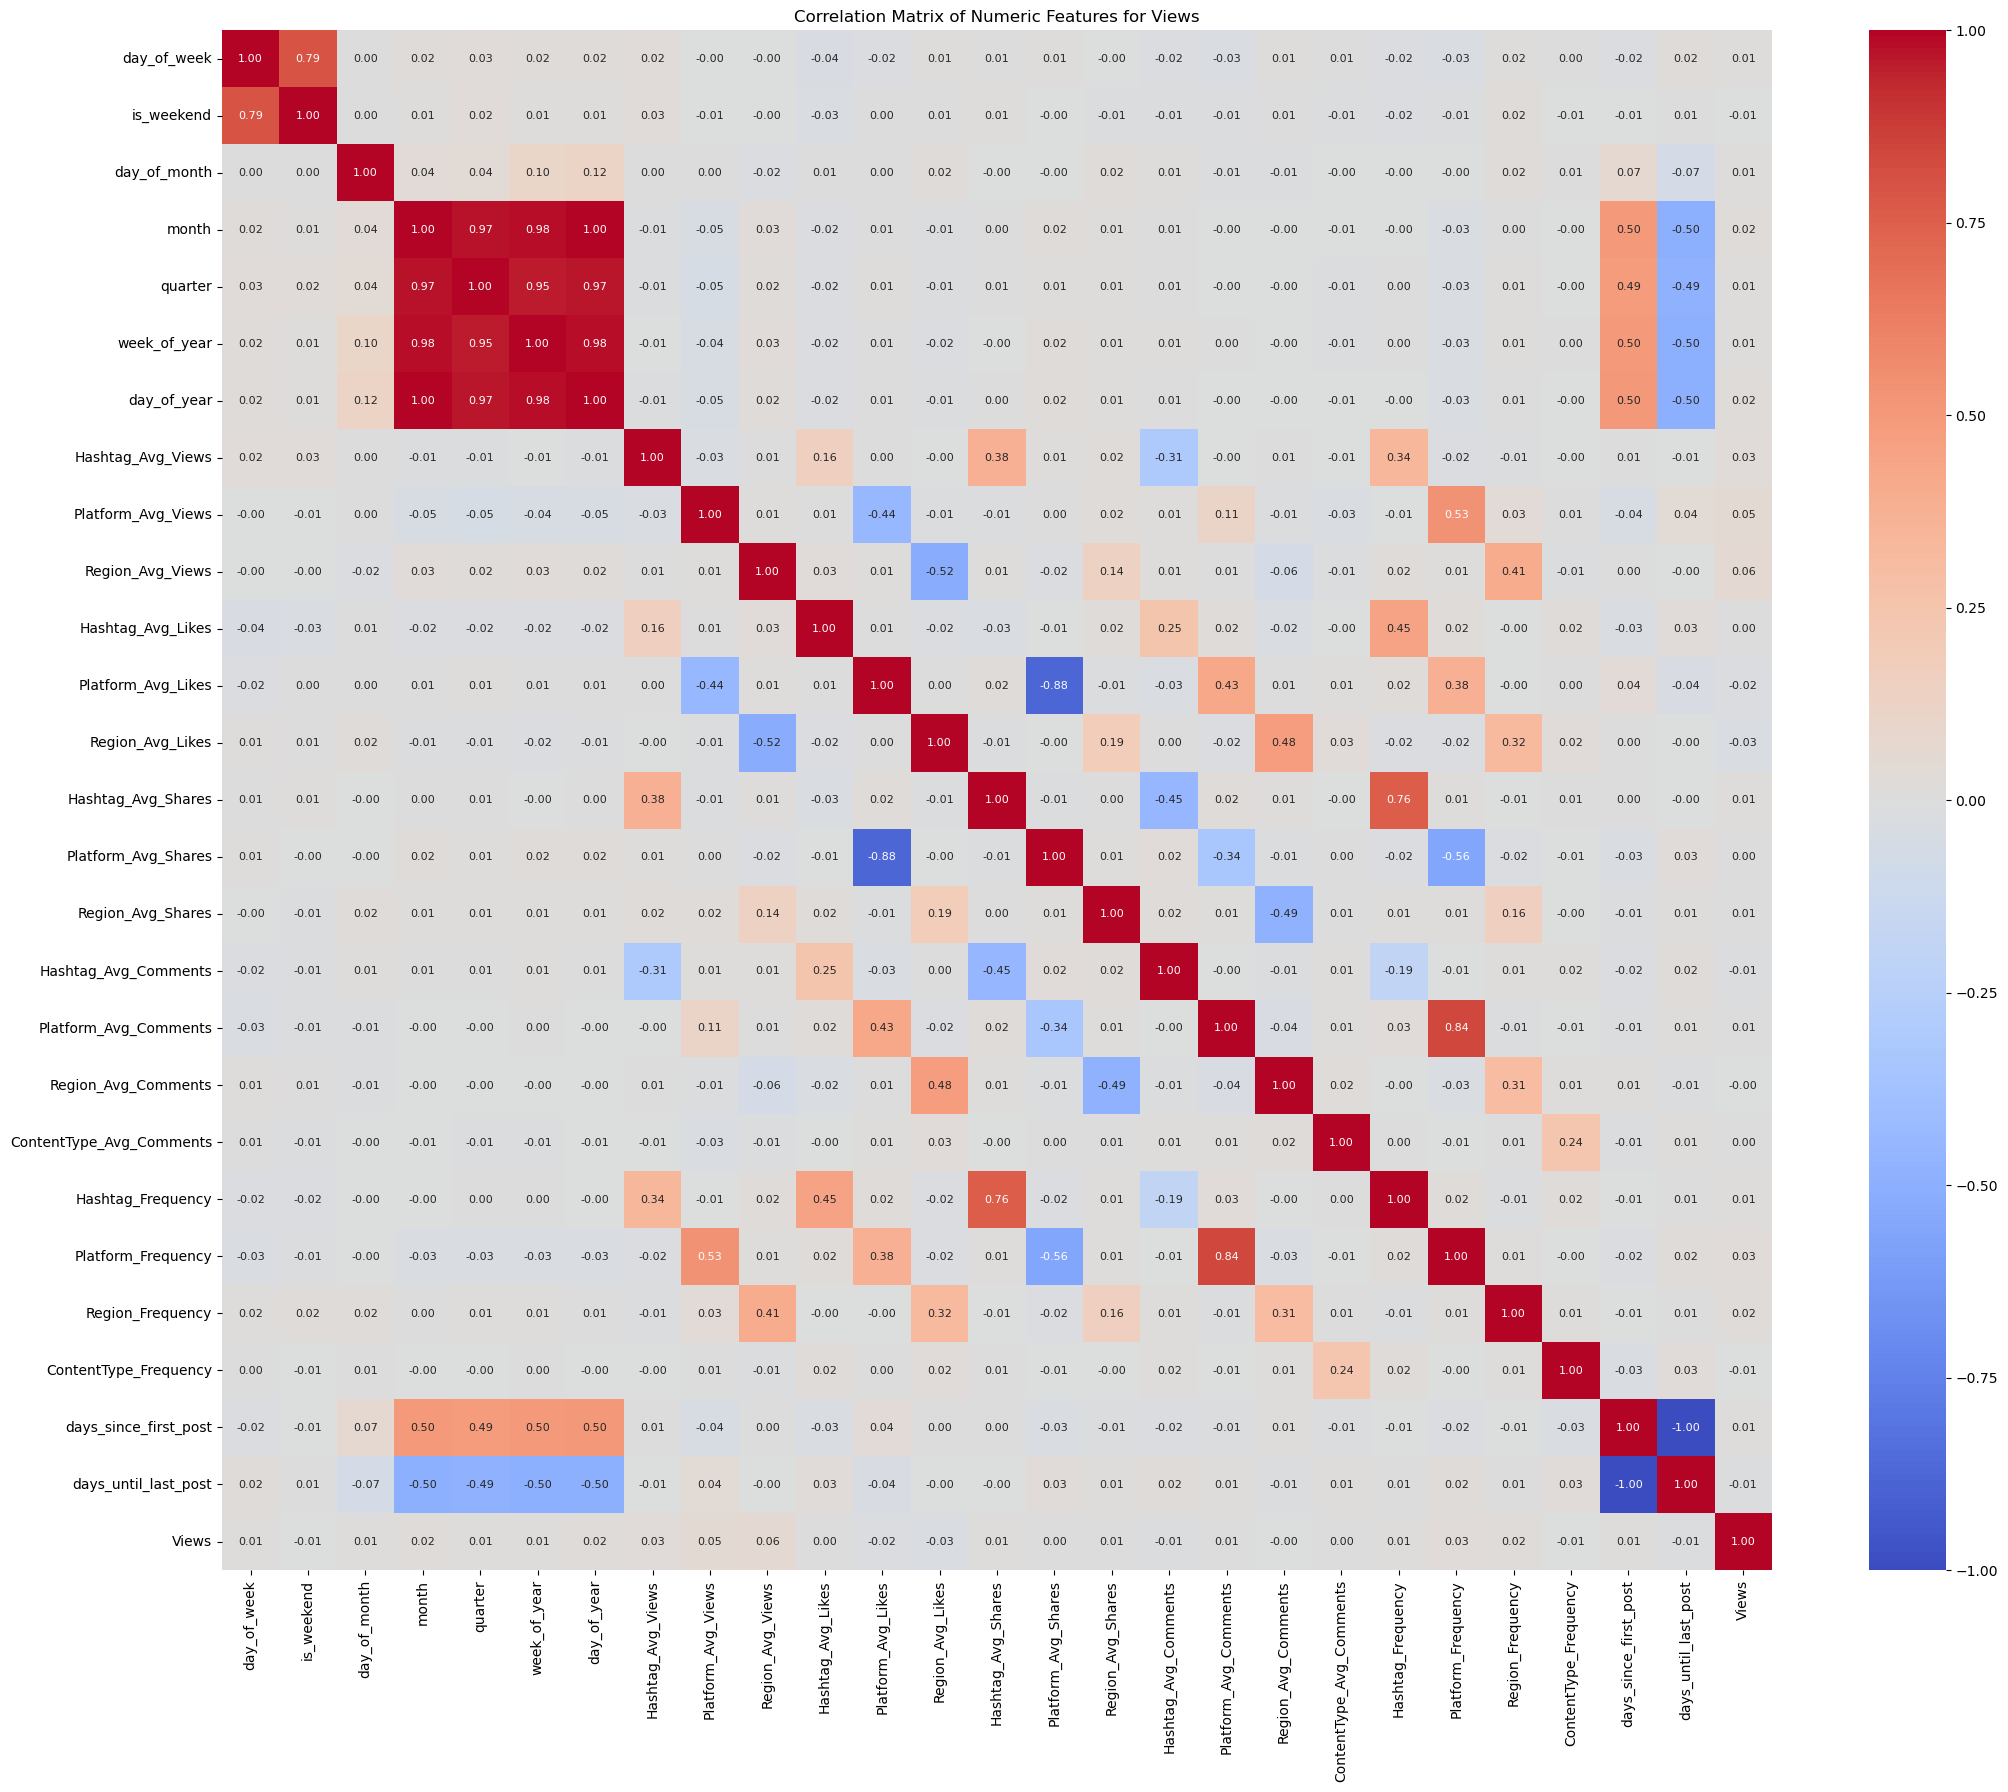

Available metrics: None (only categorical)

Columns for target 'Views':
['Platform', 'Hashtag', 'Region', 'Content_Type', 'Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
Numeric: ['Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequen

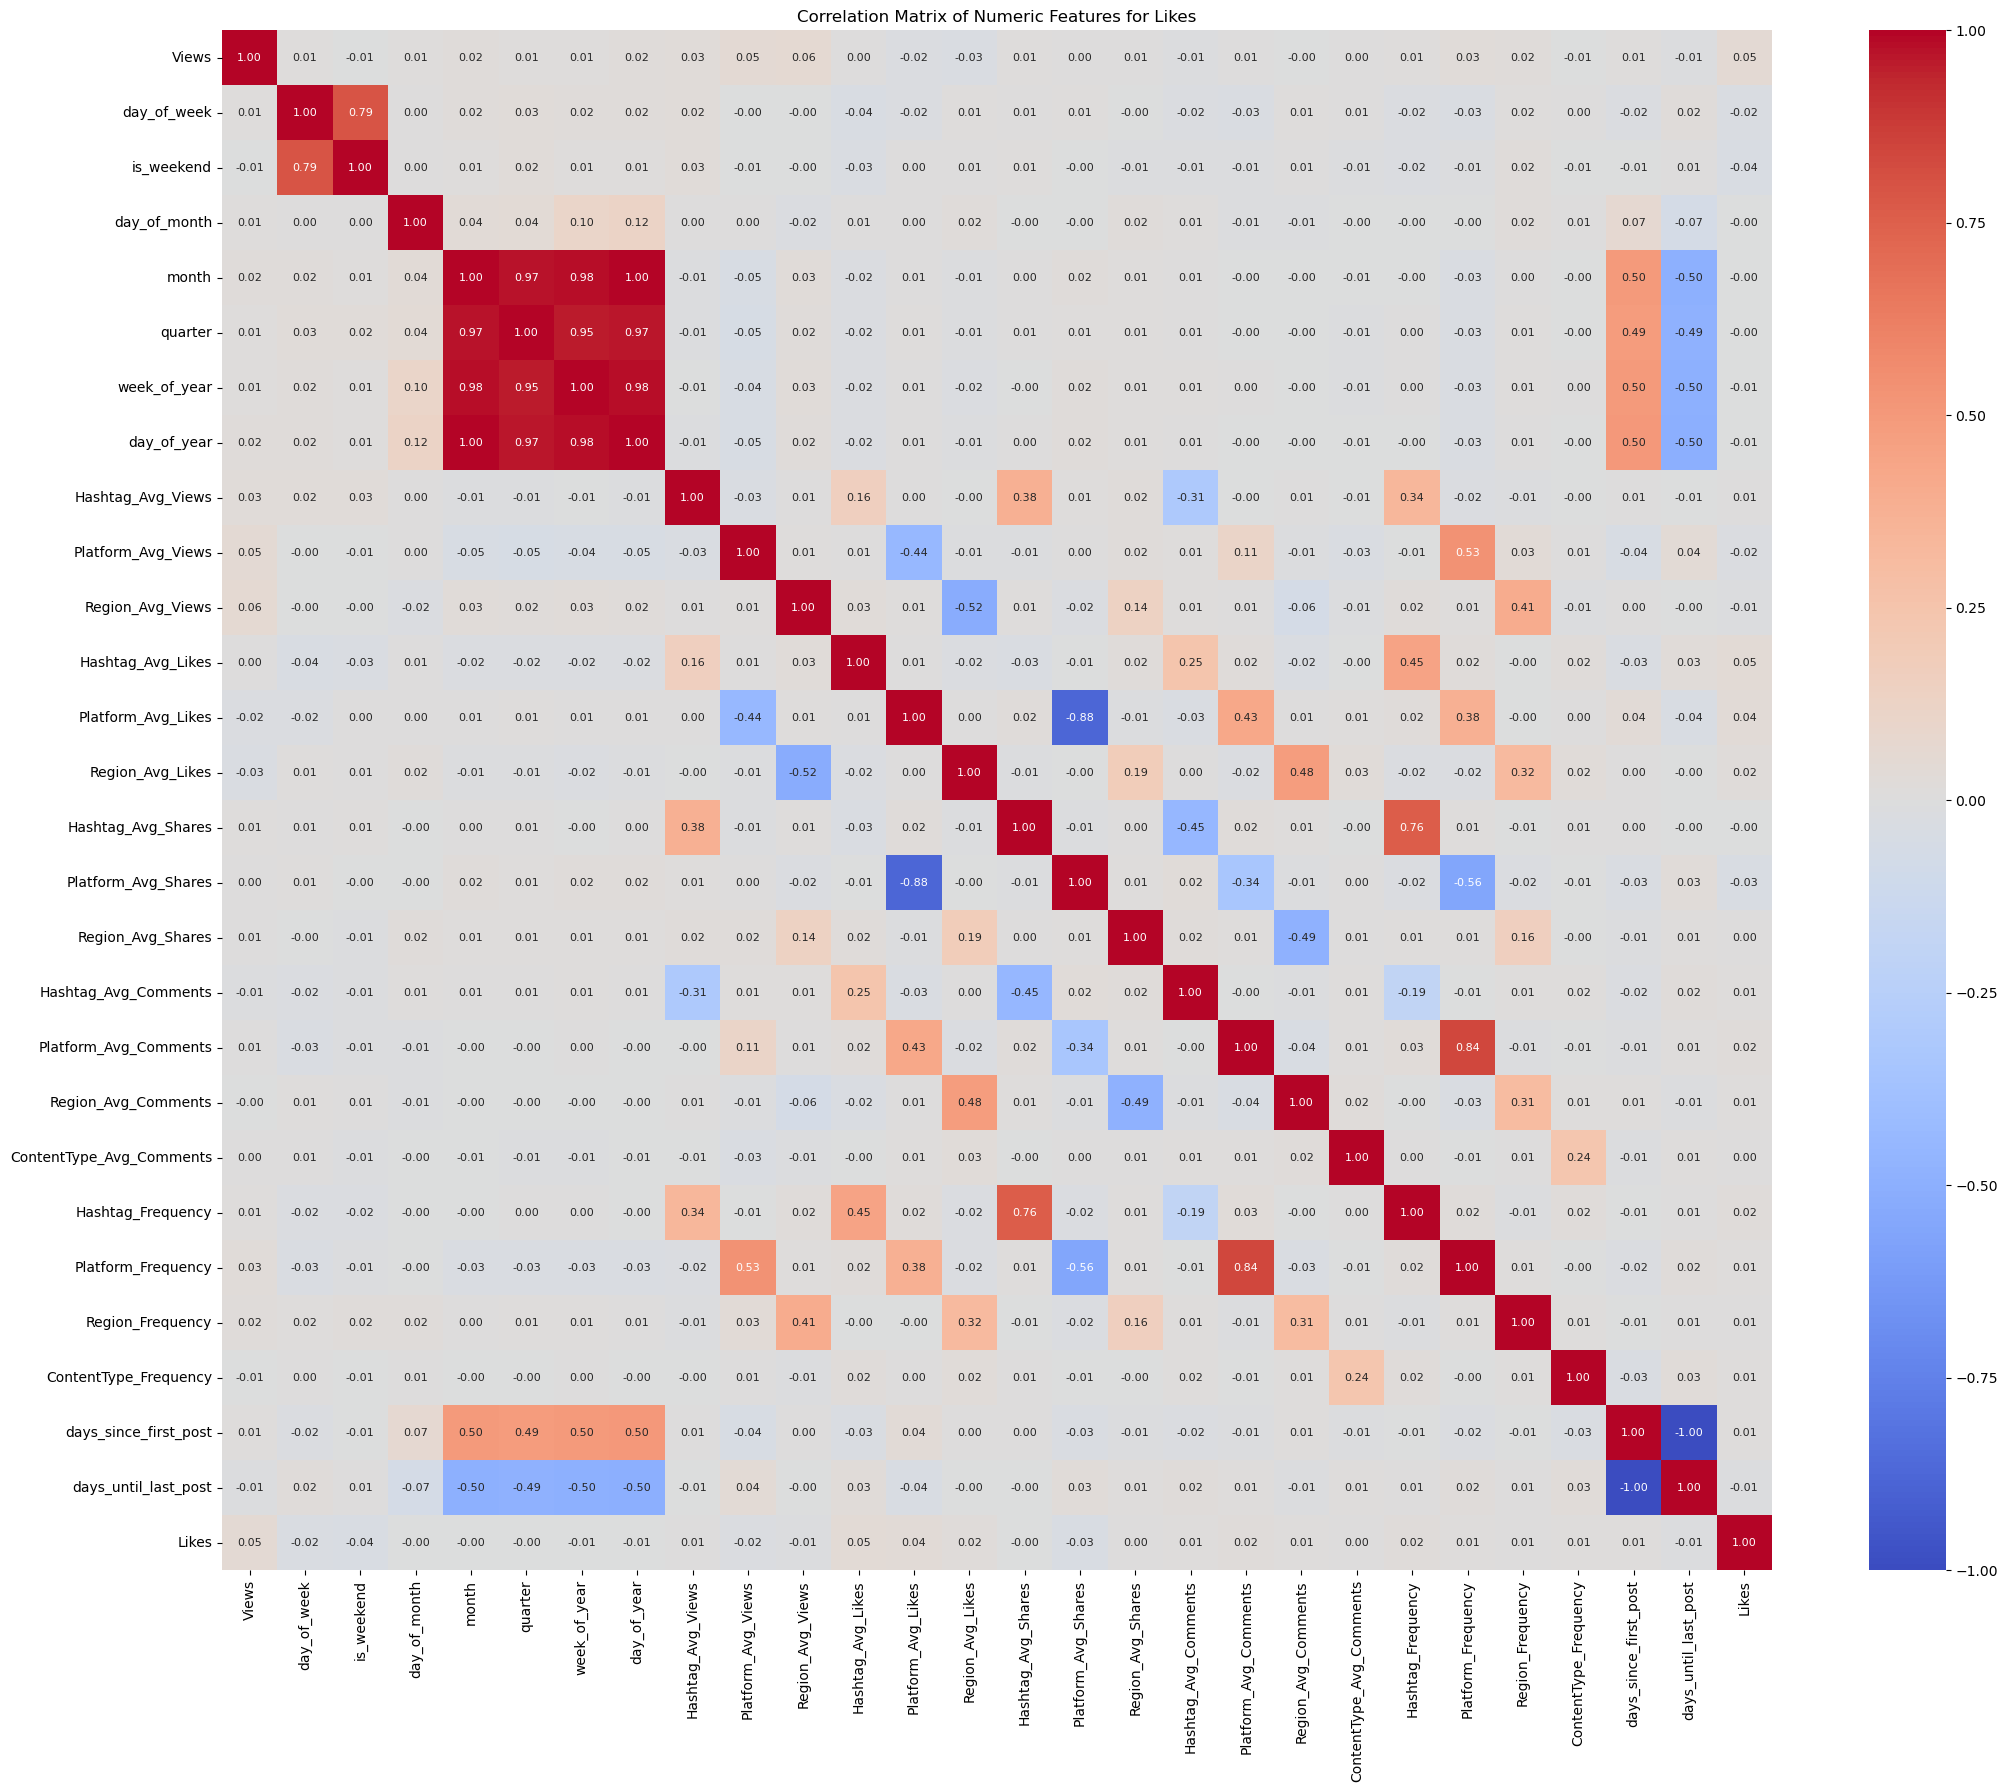

Available metrics: ['Views']

Columns for target 'Likes':
['Platform', 'Hashtag', 'Region', 'Content_Type', 'Views', 'Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
Numeric: ['Views', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Fre

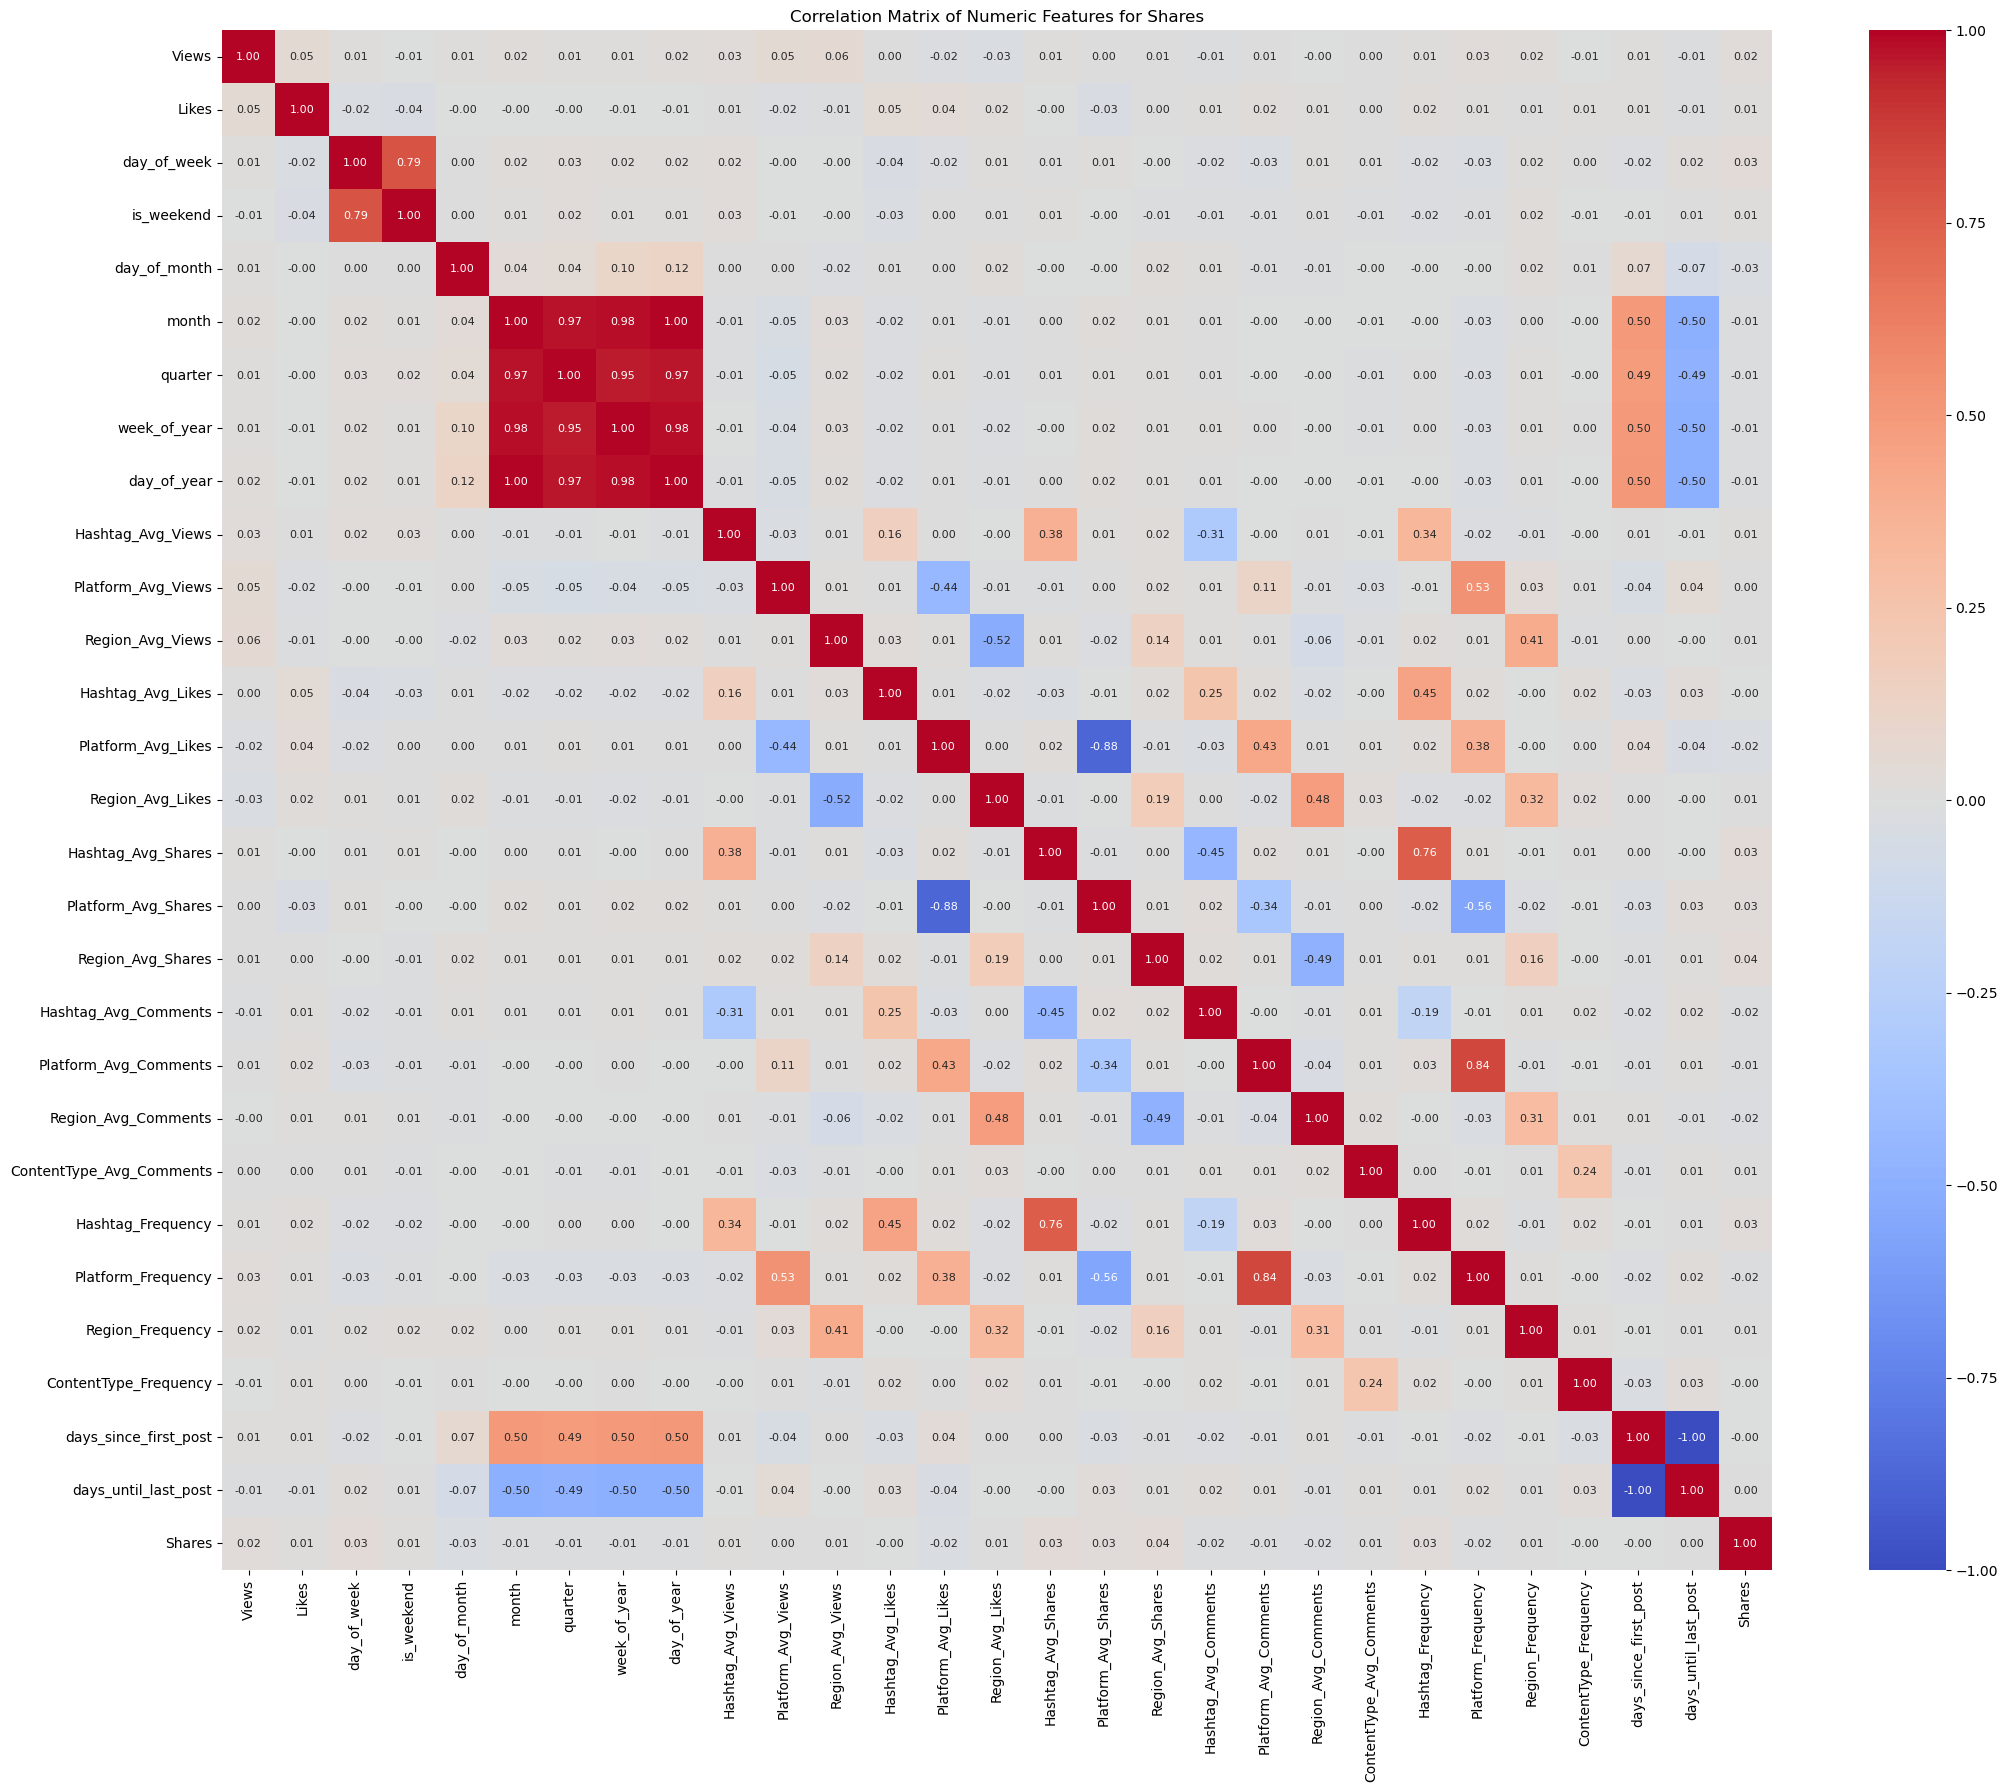

Available metrics: ['Views', 'Likes']

Columns for target 'Shares':
['Platform', 'Hashtag', 'Region', 'Content_Type', 'Views', 'Likes', 'Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
Numeric: ['Views', 'Likes', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hasht

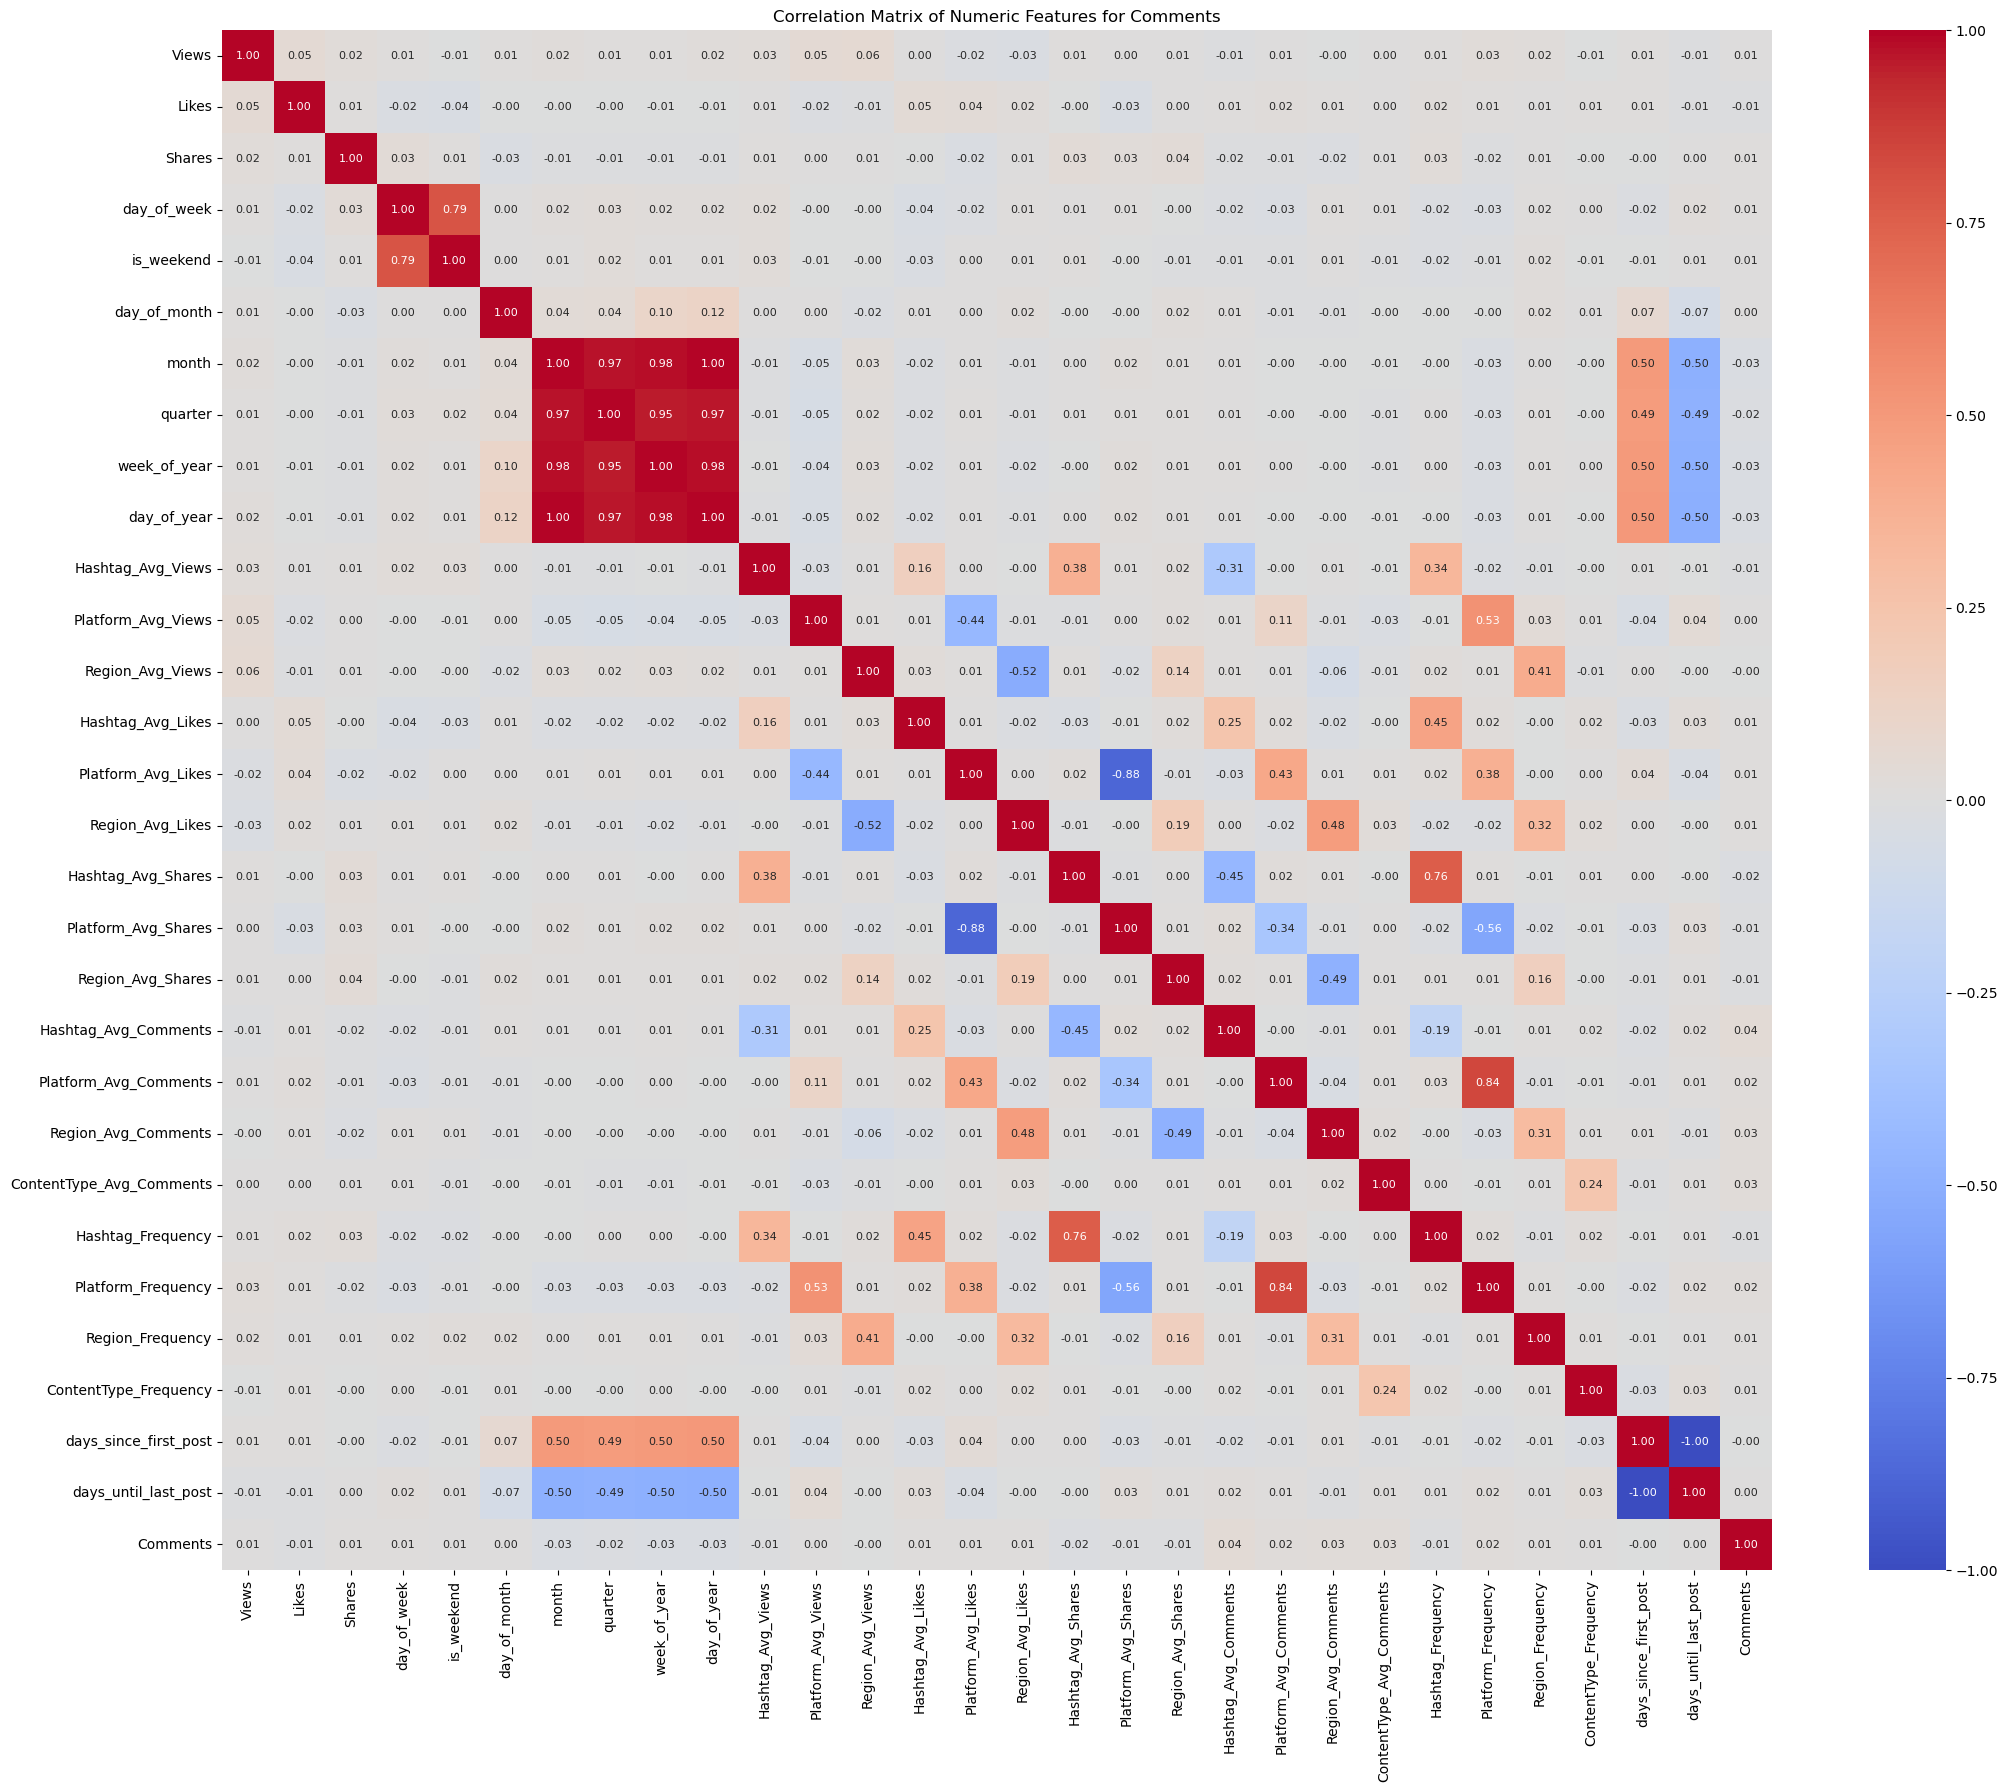

Available metrics: ['Views', 'Likes', 'Shares']

Columns for target 'Comments':
['Platform', 'Hashtag', 'Region', 'Content_Type', 'Views', 'Likes', 'Shares', 'Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
Numeric: ['Views', 'Likes', 'Shares', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'C

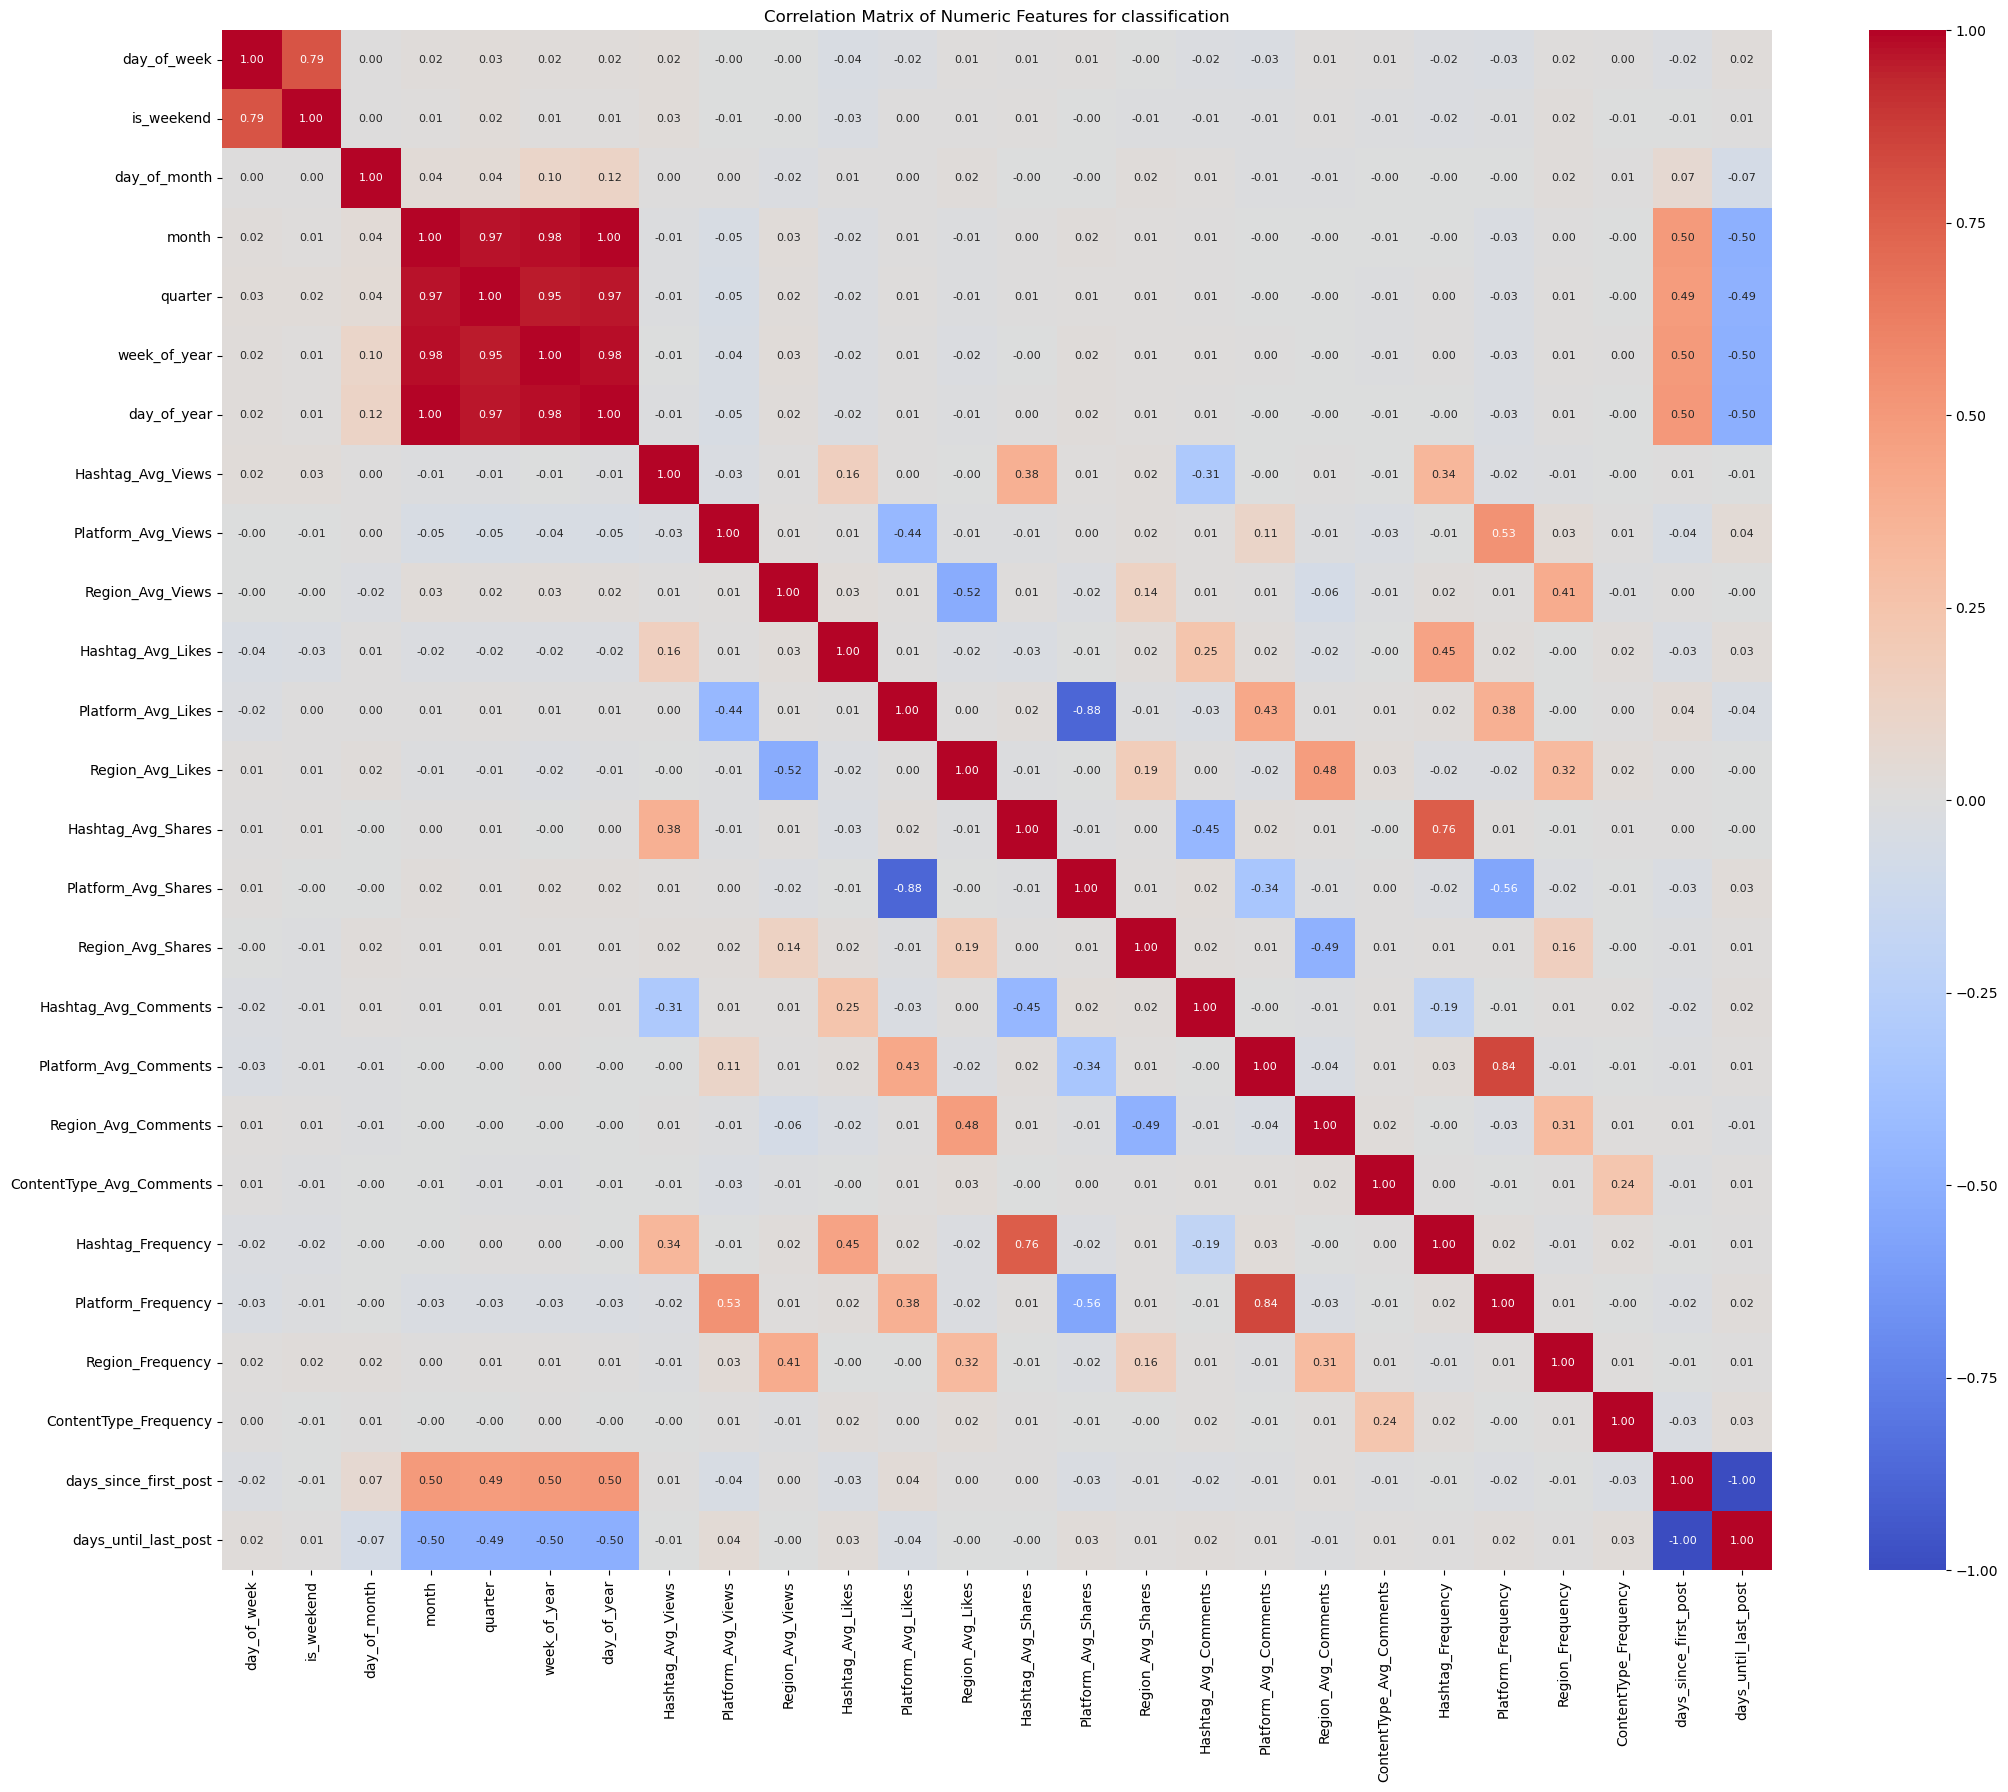


Columns for target 'classification':
['Platform', 'Hashtag', 'Region', 'Content_Type', 'Post_Date', 'day_of_week', 'is_weekend', 'day_of_month', 'month', 'quarter', 'week_of_year', 'day_of_year', 'Hashtag_Avg_Views', 'Platform_Avg_Views', 'Region_Avg_Views', 'Hashtag_Avg_Likes', 'Platform_Avg_Likes', 'Region_Avg_Likes', 'Hashtag_Avg_Shares', 'Platform_Avg_Shares', 'Region_Avg_Shares', 'Hashtag_Avg_Comments', 'Platform_Avg_Comments', 'Region_Avg_Comments', 'ContentType_Avg_Comments', 'Hashtag_Frequency', 'Platform_Frequency', 'Region_Frequency', 'ContentType_Frequency', 'days_since_first_post', 'days_until_last_post']
   TRAIN shape for classification: (3784, 47)
   TEST shape for classification:  (946, 47)
   Features for classification: 47
************************************************************
   Hashtag_Avg_Views  Platform_Avg_Views  Region_Avg_Views  Hashtag_Avg_Likes  \
0          -0.785723            0.468561          1.979219           1.791705   
1           0.573057     

In [850]:

selector = FeatureSelector(X_train, X_test, y_train_reg, y_test_reg, y_train_cal, y_test_cal)

# Get features for each task on-demand
for target in ['Views','Likes', 'Shares', 'Comments', 'classification']:
    

    if target == 'classification':
        # Classification
        X_tr, X_te, y_tr, y_te = selector.get_features_for_classification()
        selector.print_summary('classification', target)
        
        cols_for_target = list(X_tr.columns)
        print(f"\nColumns for target '{target}':")
        print(cols_for_target)
        
        numeric_cols = [col for col in NUMERIC_COLS if col in cols_for_target]
        categorical_cols = [col for col in NOMINAL_COLS if col in cols_for_target]
        
        preprocessor = build_preprocessor(categorical_cols, numeric_cols)
        preprocessor.fit(X_tr)

        # Transform
        X_tr_transformed = preprocessor.transform(X_tr)
        X_te_transformed = preprocessor.transform(X_te)

        
        print(f"   TRAIN shape for {target}: {X_tr_transformed.shape}")
        print(f"   TEST shape for {target}:  {X_te_transformed.shape}")

        # Extract feature names
        feature_names = extract_feature_names(preprocessor)
        print(f"   Features for {target}: {len(feature_names)}")
        
        print("*"*60)
        X_tr_transformed_df = pd.DataFrame(X_tr_transformed, columns=feature_names)
        print(X_tr_transformed_df.head())
        print("*"*60)

        # Save
        joblib.dump(preprocessor, ARTIFACTS_DIR / f'preprocessor-{target}.joblib')
        with open(ARTIFACTS_DIR / f'feature_names-{target}.json', 'w') as f:
            json.dump(feature_names, f, indent=2)

        print(f"\n✅ Preprocessor saved for {target}")
        
        y_tr_cat = y_tr['Engagement_Level_Cal'].astype('category')
        y_tr_cat = y_tr_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

        y_te_cat = y_te['Engagement_Level_Cal'].astype('category')
        y_te_cat = y_te_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

        # Save classification arrays
        np.savez_compressed(ARTIFACTS_DIR / f'X_train_cls_{target}.npz', data=X_tr_transformed)
        np.savez_compressed(ARTIFACTS_DIR / f'X_test_cls_{target}.npz', data=X_te_transformed)
        np.savez_compressed(ARTIFACTS_DIR / f'y_train_cls_{target}.npz', data=y_tr_cat.cat.codes.values)
        np.savez_compressed(ARTIFACTS_DIR / f'y_test_cls_{target}.npz', data=y_te_cat.cat.codes.values)
        
    
    else:    
        X_tr, X_te, y_tr, y_te = selector.get_features_for_regression(target)
        selector.print_summary('regression', target)
        
        cols_for_target = list(X_tr.columns)
        print(f"\nColumns for target '{target}':")
        print(cols_for_target)
        
        numeric_cols = [col for col in NUMERIC_COLS if col in cols_for_target]
        categorical_cols = [col for col in NOMINAL_COLS if col in cols_for_target]
        
        print("Numeric:", numeric_cols)
        print("Catogary:", categorical_cols)
        

        preprocessor = build_preprocessor(categorical_cols, numeric_cols)
        preprocessor.fit(X_tr)
        
        # Transform
        X_tr_transformed = preprocessor.transform(X_tr)
        X_te_transformed = preprocessor.transform(X_te)

        
        
    
        print(f"   TRAIN shape for {target}: {X_tr_transformed.shape}")
        print(f"   TEST shape for {target}:  {X_te_transformed.shape}")
        
        
        
        # Extract feature names
        feature_names = extract_feature_names(preprocessor)
        print(f"   Features for {target}: {len(feature_names)}")

        # Save
        joblib.dump(preprocessor, ARTIFACTS_DIR / f'preprocessor-{target}.joblib')
        with open(ARTIFACTS_DIR / f'feature_names-{target}.json', 'w') as f:
            json.dump(feature_names, f, indent=2)

        print(f"\n✅ Preprocessor saved for {target}")
        
        print(f"\n✅ Saving Regression {target} Arrays")
        
        # Save regression arrays
        np.savez_compressed(ARTIFACTS_DIR / f'X_train_reg_{target}.npz', data=X_tr_transformed)
        np.savez_compressed(ARTIFACTS_DIR / f'X_test_reg_{target}.npz', data=X_te_transformed)
        np.savez_compressed(ARTIFACTS_DIR / f'y_train_reg_{target}.npz', data=y_tr.values)
        np.savez_compressed(ARTIFACTS_DIR / f'y_test_reg_{target}.npz', data=y_te.values)


print("✅ All artifacts encoded and saved:")
print(f"   - Preprocessor & feature names")
print(f"   - Regression arrays (TRAIN/TEST)")
print(f"   - Classification arrays (TRAIN/TEST)")

#***
# TODO: Finalize the code recheck all features and columns for values
#       Comment necessary codes 
#       Refactor the code and keep good structure**#



## Encoding and Saving for Unsupervised Learning

In [851]:
df_minimal.head()

Post_Date   Platform     Hashtag Content_Type     Region    Views   Likes  \
0 2022-01-13     TikTok  #Challenge        Video         UK  4163464  339431   
1 2022-05-13  Instagram  #Education       Shorts      India  4155940  215240   
2 2022-01-07    Twitter  #Challenge        Video     Brazil  3666211  327143   
3 2022-12-05    YouTube  #Education       Shorts  Australia   917951  127125   
5 2022-11-23  Instagram  #Challenge       Shorts  Australia  1323566  136282   

   Shares  Comments Engagement_Level  ...  engagement_rate  share_rate  \
0   53135     19346             High  ...         0.081526    0.012762   
1   65860     27239           Medium  ...         0.051791    0.015847   
2   39423     36223           Medium  ...         0.089232    0.010753   
3   11687     36806              Low  ...         0.138488    0.012732   
5   86979     47129              Low  ...         0.102966    0.065716   

   comment_rate  likes_per_share  likes_per_comment  comment_to_like_ratio  \
0      0.004647         6.387967          17.544374               0.056995   
1      0.006554         3.268095           7.901615               0.126551   
2      0.009880         8.298067           9.031112               0.110725   
3      0.040096        10.876540           3.453827               0.289524   
5      0.035608         1.566820           2.891619               0.345817   

   share_to_like_ratio  virality_score  engagement_density  \
0             0.156541        0.114020            0.090028   
1             0.305983        0.093317            0.069068   
2             0.120507        0.125558            0.098990   
3             0.091932        0.224095            0.160592   
5             0.638223        0.287808            0.169635   

   Engagement_Level_Cal  
0                Medium  
1                Medium  
2                  High  
3                  High  
5                  High  

[5 rows x 35 columns]

In [852]:
preprocessor = build_preprocessor(NOMINAL_COLS, NUMERIC_COLS_UL, ORDINAL_COLS, ORDINAL_CATEGORIES)

df_ul = df_minimal.drop(columns=['Engagement_Level', 'anomaly_count','view_like_anomaly','likes_anomaly', 'shares_anomaly', 'comments_anomaly', 'any_anomaly'], errors='ignore')

df_ul.head()
print("Fitting preprocessor for Unsupervised Data...")
preprocessor.fit(df_ul)

df_transformed_ul = preprocessor.transform(df_ul)


print(f"\n✅ Encooding data for Unsupervised Learning:")
print(f"   Dataset shape: {df_transformed_ul.shape}")
# print(f"   TEST shape:  {X_test_transformed_ul.shape}")

# Extract feature names
feature_names = extract_feature_names(preprocessor)
print(f"   Features: {len(feature_names)}")

# Save
joblib.dump(preprocessor, ARTIFACTS_DIR / 'preprocessor_unsupervised.joblib')
with open(ARTIFACTS_DIR / 'feature_names-unsupervised.json', 'w') as f:
     json.dump(feature_names, f, indent=2)
    
print(f"\n✅ Preprocessor saved for Unsupervised data")

np.savez_compressed(ARTIFACTS_DIR / f'df_ul.npz', data=df_transformed_ul)
df_minimal.to_csv(ARTIFACTS_DIR / 'df_ul_minimal.csv', index=False)

print(f"\n✅saved for Unsupervised data")

Fitting preprocessor for Unsupervised Data...

✅ Encooding data for Unsupervised Learning:
   Dataset shape: (4730, 42)
   Features: 42

✅ Preprocessor saved for Unsupervised data

✅saved for Unsupervised data
